In [610]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'


In [611]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9])", fold_path)
        fold_nb = int(match[0][-1])
        fold_string=f"fold_{fold_nb}"
        if verbose: print(fold_string,  end = ' ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                if verbose:
                    if tag == 'val_acc':
                        print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                    if tag == 'val_step':
                        print(f"Max_step: {int(max(vals))}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                pass
        if verbose: print()
    print(f'#folds: {len(list_folds)}')
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_list = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    best_epochs = []
    patt_to_find = 'epoch='
    for fold_ckpt in fold_ckpts:
        idx_beg=fold_ckpt.rfind(patt_to_find)
        idx_end=fold_ckpt[idx_beg+1:].find('_')+idx_beg
        best_epochs.append(int(fold_ckpt[idx_beg+len(patt_to_find):idx_end+1]))
    
    if len(best_epochs) > 0: hparams_list['best_epoch'] = int(np.mean(best_epochs))
    hparams_list.pop('args', None)
        
    return values, hparams_list

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        max_epochs_real = max([max(el) for el in x_values])
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        
        for steps, vals in zip(x_values, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        var1 = np.var(temp_lists, axis=0)
        var2 = np.sum((np.array([el - np.mean(temp_lists, axis=0) for el in temp_lists]))**2, axis=0) / len(temp_lists)
        interp_values[f'{metric_name}_interp_var'] = var2
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])

        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]) * 0.95, '--k', linewidth=1, alpha=0.6)
        
    return ax

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=False):
    rejected_ckpts=[]
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(20,6)
    f.tight_layout()
    plt.ylim(0,1.1)
    is_labeled = np.zeros(10)
    tot_len_ckpt = len(logs_paths)
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name, end=" ")
        match=re.search(re.compile("_d([0-9]*)"), ckpt_name)
        depth=int(match.group(1)) 
        match=re.search(re.compile("_b([0-9]*)"), ckpt_name)
        b_len=int(match.group(1))
        match=re.search(re.compile("[0-9]*_([0-9]{4})_([0-9]{4})"), ckpt_name)
        date, time=match.group(1), match.group(2)
        #print(int(date[:2]), int(time[:2]), int(date[2:]))
        steps_precomputed = int(date[:2]) >= 3 and int(date[2:]) >= 5

        metric_values, hparams_list = parse_tb_logs(logs_path, metrics_to_plot,
                                                    threshold=threshold, verbose=verbose)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
            
        def create_run_dict(hparams_list, metric_values, ckpt_name):
            hparams_list['name'] = ckpt_name
            hparams_list['eval_steps'] = []
            hparams_list['best_score'] = max([max(el) for el in metric_values['val_acc']])
            return hparams_list
        
        highscore_table.append(create_run_dict(hparams_list, metric_values, ckpt_name))   
        val_steps_logged = 'val_step' in metric_values.keys()
        if val_steps_logged and steps_precomputed:
            x_values = metric_values['val_step']
        else:
            x_values = metric_values['val_loss_step']
            print("Steps adjusted")
            if b_len > 0: 
                res=[]
                for fold_vals in x_values:
                    fold_vals.insert(0, 0)
                    res.append([fold_vals[i] - fold_vals[i-1] for i in range(1, len(fold_vals))])
                x_values=res

        interp_values = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=x_values,
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)]
        
        if color_patt == None:
            cmap = plt.get_cmap(cm_names[depth - min_d])
            lightness = (hparams_list['hidden_size'] * hparams_list['lr'] / max_h / max_lr) + 0.2
            if depth < 7: lightness += 0.3 
            color = cmap(lightness)
        elif color_patt == 'discrete':
            #color = cmap(i/8) #tot_len_ckpt)
            color = None
            
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos[1]+1:label_pos[2]])+str(ckpt_name[label_pos[3]+1:])
        if plot_legend == 2:
            if not is_labeled[depth-1]: #and lightness > 0.3:
                label = str(f"depth={depth}")
                is_labeled[depth-1] = True
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=x_values, color=color)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return rejected_ckpts, highscore_table

In [508]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_step']
max_h = 1000
max_lr = 10.0
min_d = 5


In [ ]:
# loop over all files in directory

all_ckpt_dirs = os.listdir(LOG_PATH)
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
#all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]
#all_ckpt_dirs = all_ckpt_dirs[:20]

logs_paths = [join(LOG_PATH,ckpt) for ckpt in all_ckpt_dirs]
print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                   all_ckpt_dirs, 
                                                   name="all_plots_>0.75", tot_num_values=50, 
                                                   plot_legend=2,
                                                   threshold=0.8)
plt.show()

In [ ]:
highscore_table = sorted(highscore_table, key=lambda d: d['best_epoch'], reverse=False) 
highscore_table = sorted(highscore_table, key=lambda d: (d['best_score'], d['hidden_size']), reverse=True) 


print(highscore_table[0])

print_format_str = "{:<24} {:<4} {:<5} {:<7} {:<6} {:<4} {:<5}"

print('____________________________________________________')
print(print_format_str.format('name', 'lr', 'mode','h_size','#class', 'ep', 'best_score'))
for el in highscore_table:
    name=el['name']
    idx = [i for i in range(len(name)) if name.startswith('_', i)][3]
    name=name[idx+1:]
    print (print_format_str.format(name, el['lr'], el['mode'], el['hidden_size'], 
                                    el['nb_classes'], el['best_epoch'], el['best_score']))


# Filtered graphs

#logged paths : 6 
27158430_2704_2336_synth_rand_b0_d5_h25_lr2.0 fold_2 val_loss 12, val_acc 12, Max_acc: 0.962 val_step 12, 
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_step 16, 
fold_1 val_loss 14, val_acc 14, Max_acc: 0.966 val_step 14, 
#folds: 3
Steps adjusted
27156821_2704_1354_synth_um_b0_d5_h25_lr2.0 fold_2 val_loss 400, val_acc 400, Max_acc: 0.969 val_step 400, 
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_step 456, 
fold_1 val_loss 428, val_acc 428, Max_acc: 0.953 val_step 428, 
#folds: 3
Steps adjusted
27140968_2404_1655_synth_um_b1_d5_h25_lr2.0 fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 warning: val_step not in logs 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 warning: val_step not in logs 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 warning: val_step not in logs 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 warning: val_step not in logs 
#folds: 4
Steps adjusted
27140969_2404_1655_synth_um_b10_d5_h25_lr2.0 fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 warning

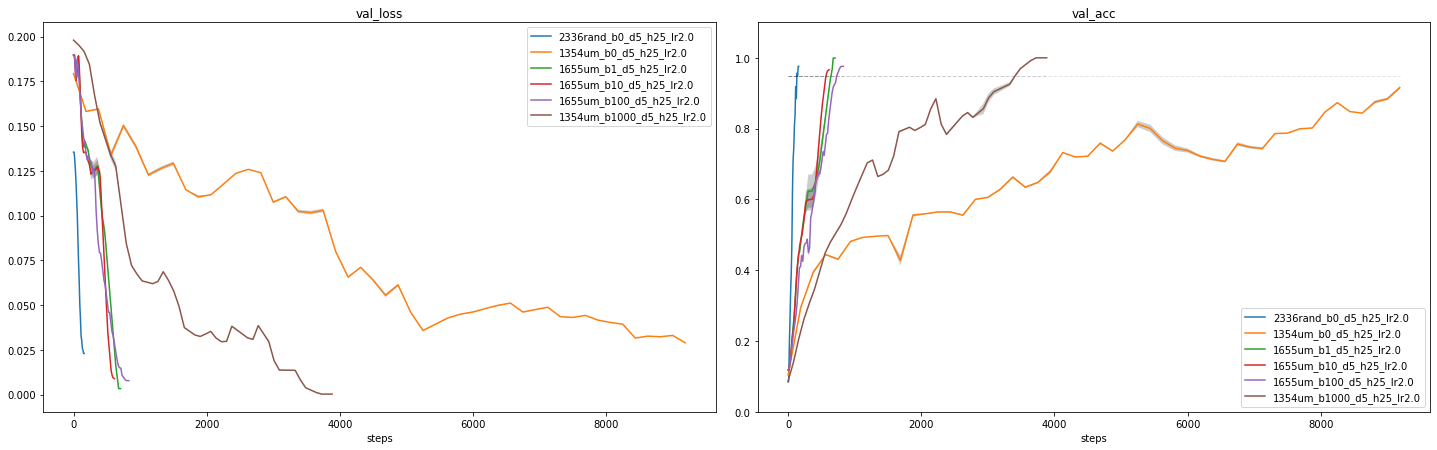

#logged paths : 5 
27158434_2704_2337_synth_rand_b0_d6_h25_lr2.0 fold_2 val_loss 36, val_acc 36, Max_acc: 0.956 val_step 36, 
fold_0 val_loss 47, val_acc 47, Max_acc: 0.969 val_step 47, 
fold_1 val_loss 43, val_acc 43, Max_acc: 0.978 val_step 43, 
#folds: 3
Steps adjusted
27158422_2704_2333_synth_um_b0_d6_h25_lr2.0 fold_0 val_loss 196, val_acc 196, Max_acc: 0.952 val_step 196, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.969 val_step 379, 
#folds: 2
Steps adjusted
27126694_2004_1530_synth_um_b10_d6_h25_lr2.0 fold_0 val_loss 13, val_acc 13, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted
27160272_2804_2149_synth_um_b100_d6_h25_lr2.0 fold_0 val_loss 7, val_acc 7, Max_acc: 1.0 val_step 7, 
fold_1 val_loss 7, val_acc 7, Max_acc: 1.0 val_step 7, 
#folds: 2
Steps adjusted
27160274_2804_2149_synth_um_b1000_d6_h25_lr2.0 fold_0 val_loss 13, val_acc 13, Max_acc: 0.966 val_step 13, 
fold_1 val_loss 13, val_acc 13, Max_acc: 0.977 val_step 13, 
#folds: 2
Steps adjusted


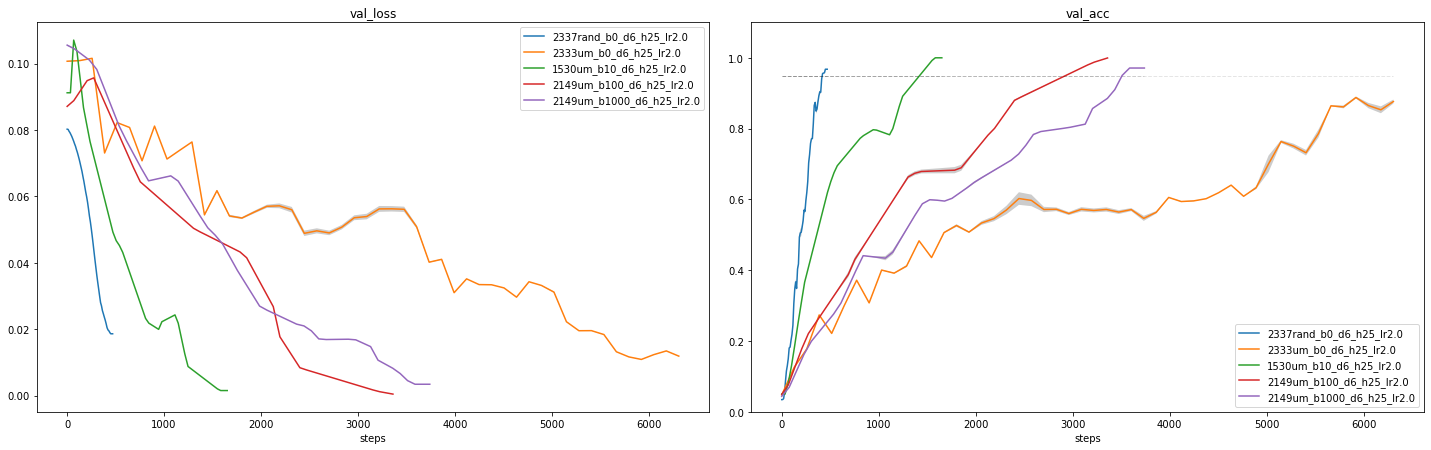

#logged paths : 8 
27166074_2904_1631_synth_um_b0_d7_h100_lr2.0 fold_0 val_loss 1765, val_acc 1765, Max_acc: 0.932 val_step 1765, 
fold_1 val_loss 1348, val_acc 1348, Max_acc: 0.959 val_step 1348, 
#folds: 2
Steps adjusted
27158443_2704_2340_synth_rand_b0_d7_h100_lr2.0 fold_2 val_loss 103, val_acc 103, Max_acc: 0.974 val_step 103, 
fold_0 val_loss 106, val_acc 106, Max_acc: 0.968 val_step 106, 
fold_1 val_loss 107, val_acc 107, Max_acc: 0.957 val_step 107, 
#folds: 3
Steps adjusted
27127877_2104_1127_synth_um_b1_d7_h100_lr2.0 fold_0 val_loss 24, val_acc 24, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted
27174430_3004_1129_synth_um_b10_d7_h100_lr2.0 fold_0 val_loss 9, val_acc 9, Max_acc: 0.512 unsuccessful run
27189187_0205_1354_synth_um_b10_d7_h100_lr2.0 fold_0 val_loss 7, val_acc 7, Max_acc: 0.669 unsuccessful run
27174432_3004_1137_synth_um_b100_d7_h100_lr2.0 fold_0 val_loss 12, val_acc 12, Max_acc: 0.699 unsuccessful run
27174434_3004_1232_synth_um_b1000_d7_h10

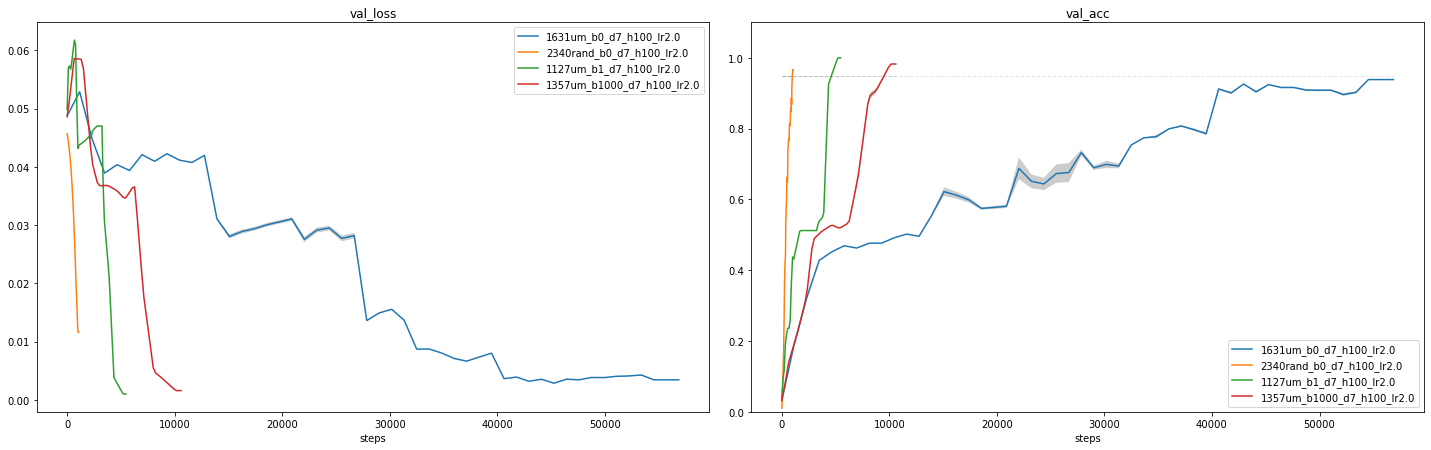

#logged paths : 7 
27158457_2704_2347_synth_rand_b0_d8_h200_lr5.0 fold_2 val_loss 144, val_acc 144, Max_acc: 0.957 val_step 144, 
fold_0 val_loss 138, val_acc 138, Max_acc: 0.957 val_step 138, 
fold_1 val_loss 151, val_acc 151, Max_acc: 0.96 val_step 151, 
#folds: 3
Steps adjusted
27160156_2804_2006_synth_um_b0_d8_h200_lr5.0 fold_0 val_loss 1126, val_acc 1126, Max_acc: 0.951 val_step 1126, 
fold_1 val_loss 738, val_acc 738, Max_acc: 0.953 val_step 738, 
#folds: 2
Steps adjusted
27194177_0305_2226_synth_um_b1_d8_h200_lr5.0 fold_0 val_loss 10, val_acc 10, Max_acc: 0.692 unsuccessful run
27166097_2904_1718_synth_um_b100_d8_h200_lr5.0 fold_0 val_loss 9, val_acc 9, Max_acc: 1.0 val_step 9, 
fold_1 val_loss 8, val_acc 8, Max_acc: 1.0 val_step 8, 
#folds: 2
Steps adjusted
27166099_2904_1725_synth_um_b1000_d8_h200_lr5.0 fold_0 val_loss 16, val_acc 16, Max_acc: 0.804 unsuccessful run
27194183_0305_2226_synth_um_b1000_d8_h200_lr5.0 fold_0 val_loss 5, val_acc 5, Max_acc: 0.883 unsuccessful run
27

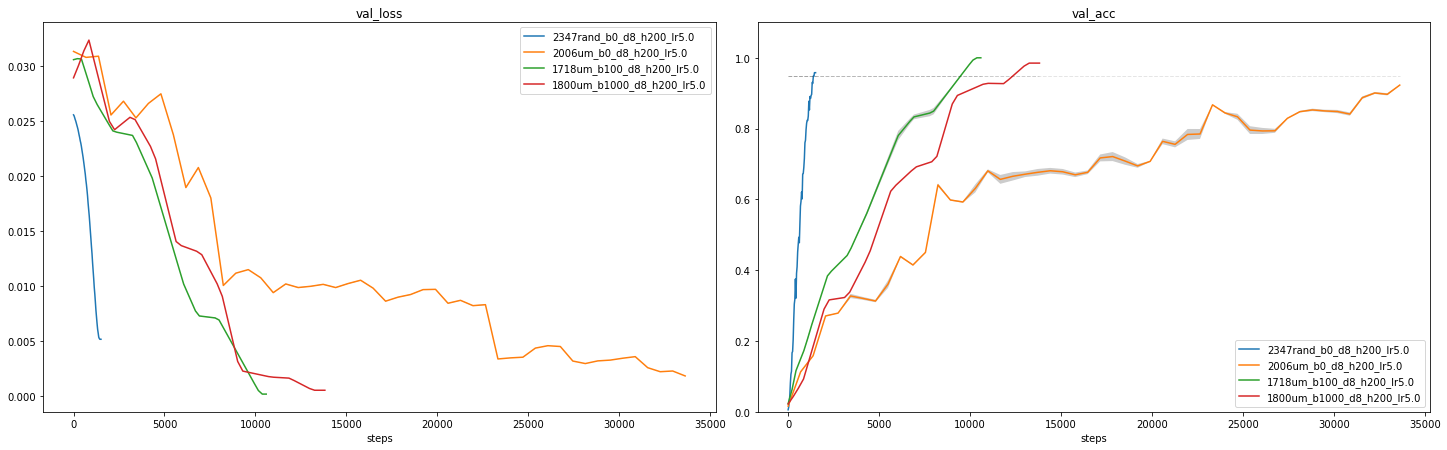

#logged paths : 6 
27147228_2504_1617_synth_um_b0_d8_h300_lr5.0 fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 warning: val_step not in logs 
#folds: 1
Steps adjusted
27158461_2704_2350_synth_rand_b0_d8_h300_lr5.0 fold_2 val_loss 121, val_acc 121, Max_acc: 0.952 val_step 121, 
fold_0 val_loss 125, val_acc 125, Max_acc: 0.953 val_step 125, 
fold_1 val_loss 131, val_acc 131, Max_acc: 0.97 val_step 131, 
#folds: 3
Steps adjusted
27127994_2104_1329_synth_um_b1_d8_h300_lr5.0 fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted
27137832_2404_1155_synth_um_b10_d8_h300_lr5.0 fold_2 val_loss 15, val_acc 15, Max_acc: 0.877 unsuccessful run
27189206_0205_1409_synth_um_b1000_d8_h300_lr5.0 fold_0 val_loss 12, val_acc 12, Max_acc: 0.984 val_step 12, 
fold_1 val_loss 10, val_acc 10, Max_acc: 0.987 val_step 10, 
#folds: 2
Steps adjusted
27174448_3004_1246_synth_um_b1000_d8_h300_lr5.0 fold_0 val_loss 16, val_acc 16, Max_acc: 0.818 unsuccessful run


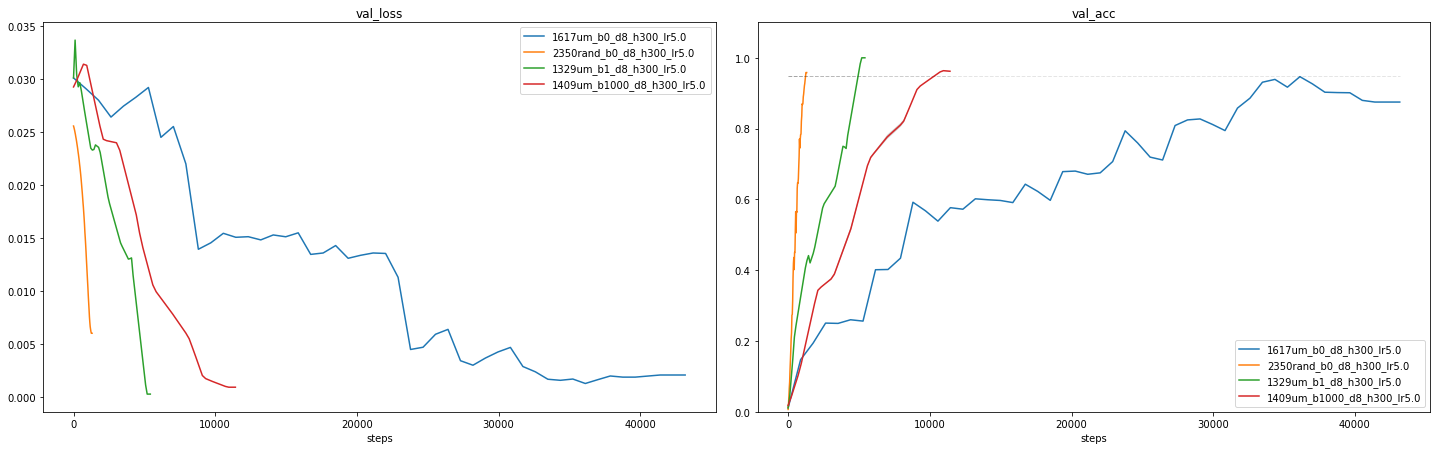

#logged paths : 7 
27158466_2704_2351_synth_rand_b0_d9_h300_lr5.0 fold_2 val_loss 418, val_acc 418, Max_acc: 0.951 val_step 418, 
fold_0 val_loss 436, val_acc 436, Max_acc: 0.963 val_step 436, 
fold_1 val_loss 422, val_acc 422, Max_acc: 0.956 val_step 422, 
#folds: 3
Steps adjusted
27172882_3004_0108_synth_um_b0_d9_h300_lr5.0 fold_0 val_loss 621, val_acc 621, Max_acc: 0.951 val_step 621, 
fold_1 val_loss 489, val_acc 489, Max_acc: 0.953 val_step 489, 
#folds: 2
Steps adjusted
27172827_2904_2311_synth_um_b10_d9_h300_lr5.0 fold_0 val_loss 6, val_acc 6, Max_acc: 0.861 unsuccessful run
27172830_2904_2314_synth_um_b100_d9_h300_lr5.0 fold_0 val_loss 7, val_acc 7, Max_acc: 0.914 val_step 7, 
fold_1 val_loss 7, val_acc 7, Max_acc: 0.975 val_step 7, 
#folds: 2
Steps adjusted
27174493_3004_1430_synth_um_b1000_d9_h300_lr5.0 fold_0 val_loss 10, val_acc 10, Max_acc: 0.836 unsuccessful run
27172832_2904_2324_synth_um_b1000_d9_h300_lr5.0 fold_0 val_loss 13, val_acc 13, Max_acc: 0.745 unsuccessful run

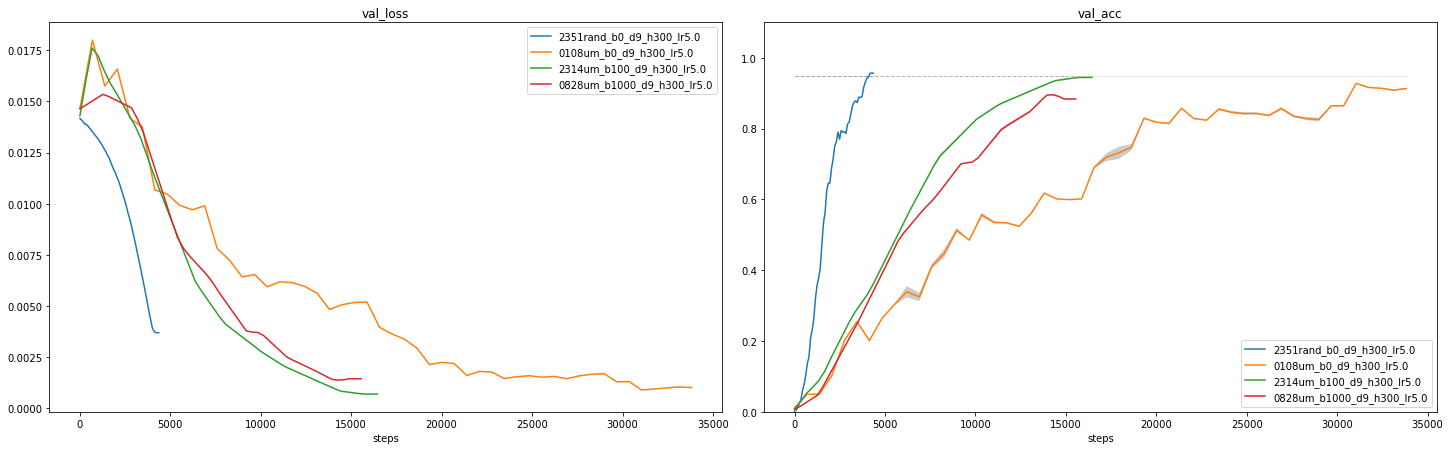

#logged paths : 2 
27174509_3004_1527_synth_um_b0_d10_h750_lr10.0 fold_0 val_loss 332, val_acc 332, Max_acc: 0.954 val_step 332, 
fold_1 val_loss 291, val_acc 291, Max_acc: 0.958 val_step 291, 
#folds: 2
Steps adjusted
27172864_2904_2331_synth_rand_b0_d10_h750_lr10.0 fold_2 val_loss 581, val_acc 581, Max_acc: 0.953 val_step 581, 
fold_0 val_loss 556, val_acc 556, Max_acc: 0.953 val_step 556, 
fold_1 val_loss 580, val_acc 580, Max_acc: 0.953 val_step 580, 
#folds: 3
Steps adjusted


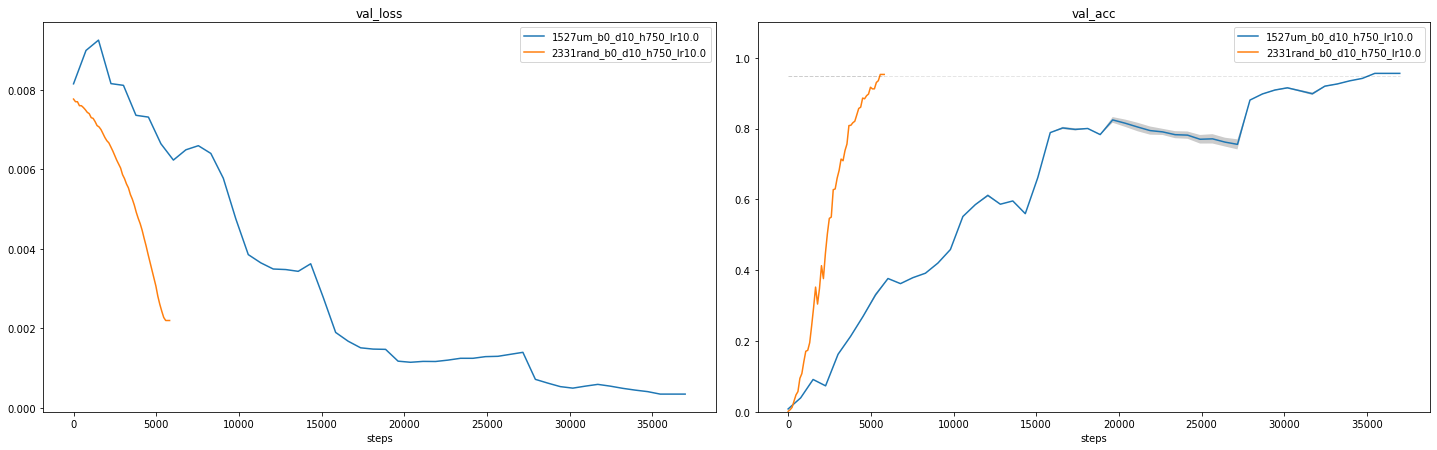

In [477]:
# example name: 27135056_2304_1747_synth_um_b1000_d5_h25_lr5

def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                       all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=50, 
                                                       plot_legend=1,
                                                       threshold=threshold, color_patt='discrete',
                                                       verbose=verbose)
    plt.show()

patts_to_search = ["d5_h25_lr2", "d6_h25_lr2","d7_h100_lr2", "d8_h200_lr5", "d8_h300_lr5","d9_h300_lr5", "d10_h750_lr10"]
#patts_to_search = ["d7_h100_lr5", "d8_h200_lr5", "d8_h300_lr5","d9_h300_lr5", "d9_h500_lr5", "d10_h500_lr"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.9, log_path=LOG_PATH, verbose=True)


#logged paths : 5 
27146929_2504_1440_synth_um_b1_d5_h25_lr10.0 fold_0 val_loss 34, val_acc 34, Max_acc: 0.0906 unsuccessful run
27137821_2404_1154_synth_um_b1_d5_h25_lr5.0 fold_3 val_loss 9, val_acc 9, Max_acc: 0.981 warning: val_step not in logs 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 warning: val_step not in logs 
fold_0 val_loss 6, val_acc 6, Max_acc: 1.0 warning: val_step not in logs 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 warning: val_step not in logs 
#folds: 4
Steps adjusted
27140968_2404_1655_synth_um_b1_d5_h25_lr2.0 fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 warning: val_step not in logs 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 warning: val_step not in logs 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 warning: val_step not in logs 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 warning: val_step not in logs 
#folds: 4
Steps adjusted
27146928_2504_1440_synth_um_b1_d5_h25_lr1.0 fold_3 val_loss 13, val_acc 13, Max_acc: 1.0 warning: val_step not in logs 
fold_2 val_

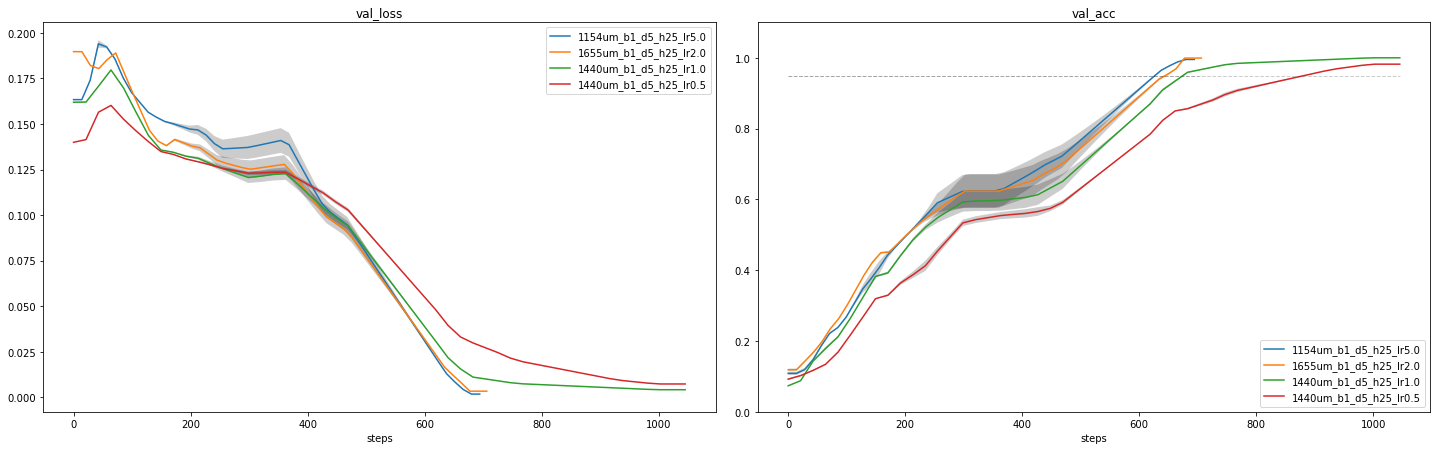

#logged paths : 2 
27137826_2404_1154_synth_um_b1_d6_h25_lr5.0 fold_3 val_loss 9, val_acc 9, Max_acc: 1.0 warning: val_step not in logs 
fold_2 val_loss 8, val_acc 8, Max_acc: 0.962 warning: val_step not in logs 
fold_0 val_loss 11, val_acc 11, Max_acc: 0.981 warning: val_step not in logs 
fold_1 val_loss 11, val_acc 11, Max_acc: 1.0 warning: val_step not in logs 
#folds: 4
Steps adjusted
27127858_2104_1119_synth_um_b1_d6_h25_lr3.0 fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 warning: val_step not in logs 
#folds: 1
Steps adjusted


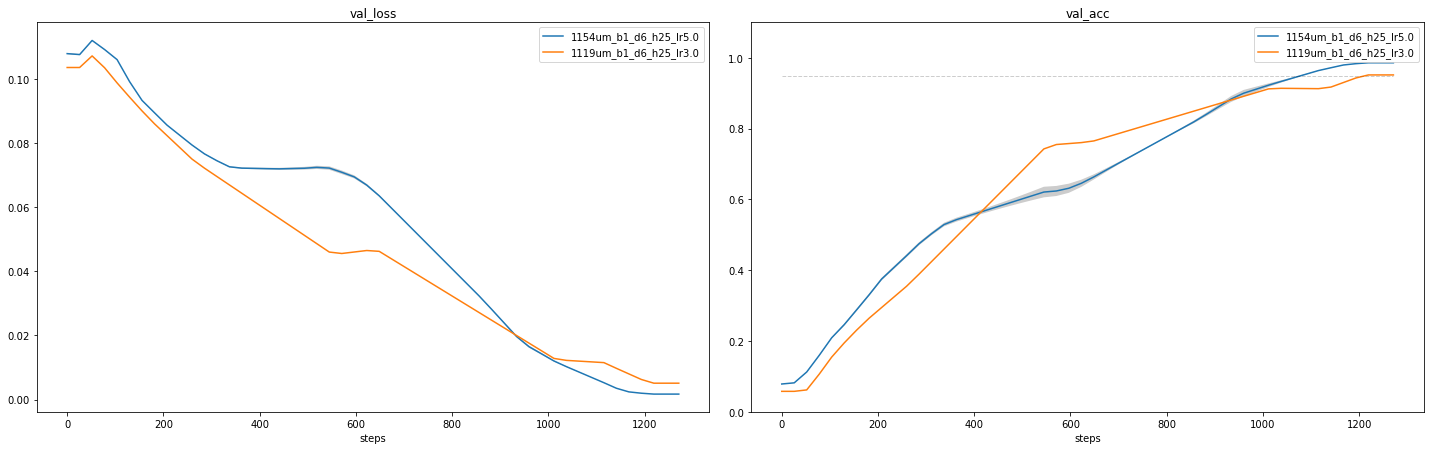

#logged paths : 3 
27127956_2104_1218_synth_um_b1_d7_h100_lr10.0 fold_0 val_loss 23, val_acc 23, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127878_2104_1127_synth_um_b1_d7_h100_lr3.0 fold_0 val_loss 23, val_acc 23, Max_acc: 0.958 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127877_2104_1127_synth_um_b1_d7_h100_lr2.0 fold_0 val_loss 24, val_acc 24, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted


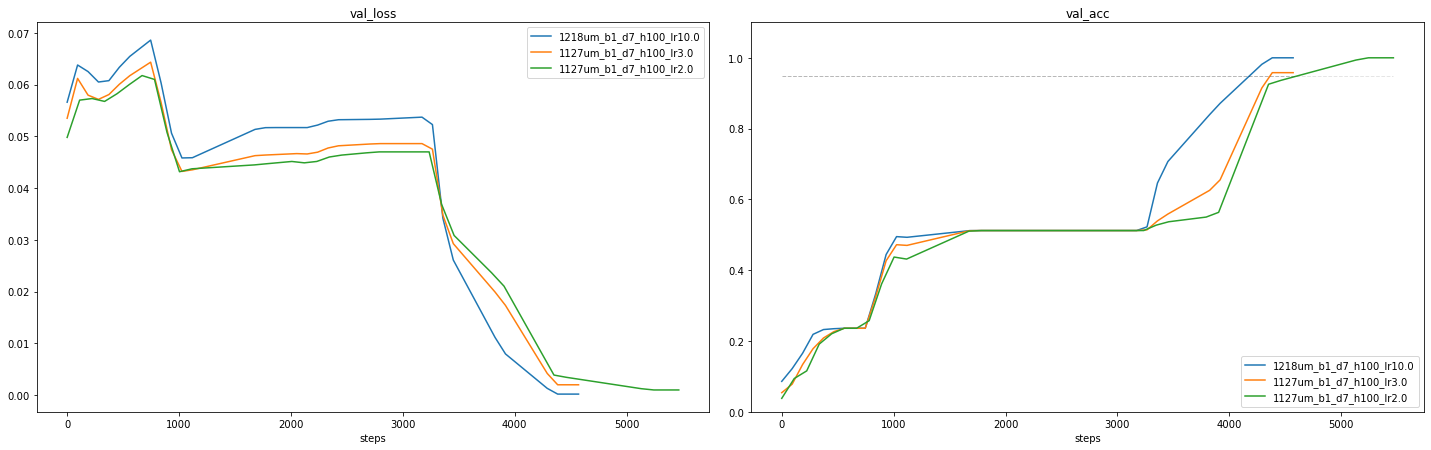

#logged paths : 4 
27147181_2504_1534_synth_um_b1_d8_h300_lr10.0 fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127994_2104_1329_synth_um_b1_d8_h300_lr5.0 fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127993_2104_1329_synth_um_b1_d8_h300_lr2.0 fold_0 val_loss 16, val_acc 16, Max_acc: 0.98 warning: val_step not in logs 
#folds: 1
Steps adjusted
27147180_2504_1527_synth_um_b1_d8_h300_lr1.0 fold_0 val_loss 17, val_acc 17, Max_acc: 0.812 warning: val_step not in logs 
#folds: 1
Steps adjusted


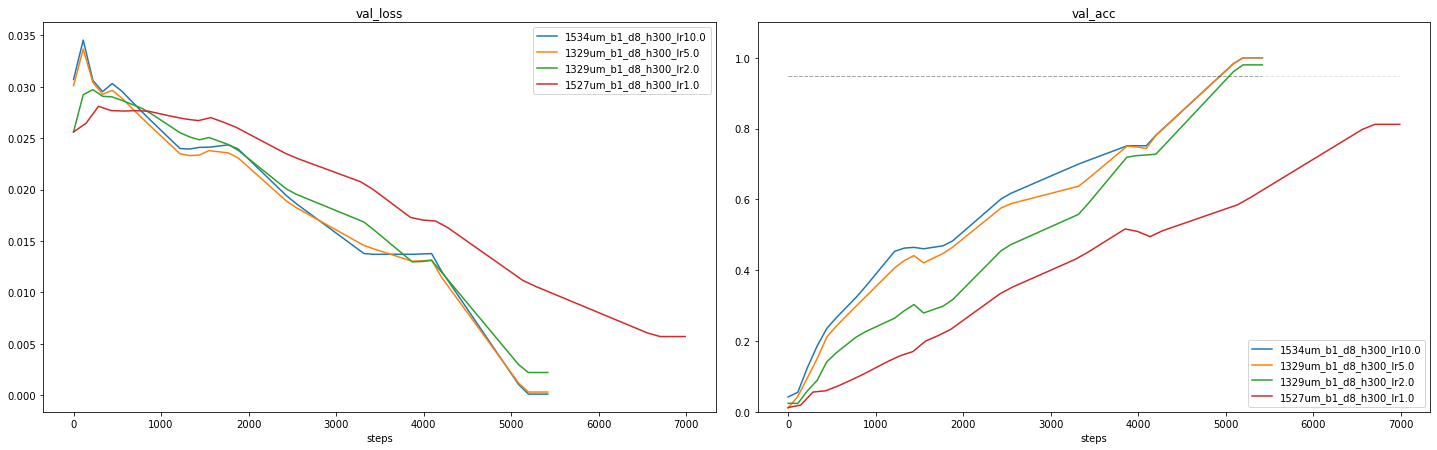

#logged paths : 5 
27127963_2104_1218_synth_um_b1_d9_h500_lr10.0 fold_0 val_loss 11, val_acc 11, Max_acc: 0.998 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127962_2104_1218_synth_um_b1_d9_h500_lr5.0 fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127800_2104_0802_synth_um_b1_d9_h500_lr2.0 fold_0 val_loss 12, val_acc 12, Max_acc: 0.667 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127799_2104_0800_synth_um_b1_d9_h500_lr1.5 fold_0 val_loss 12, val_acc 12, Max_acc: 0.491 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127798_2104_0800_synth_um_b1_d9_h500_lr1.0 fold_0 val_loss 12, val_acc 12, Max_acc: 0.386 warning: val_step not in logs 
#folds: 1
Steps adjusted


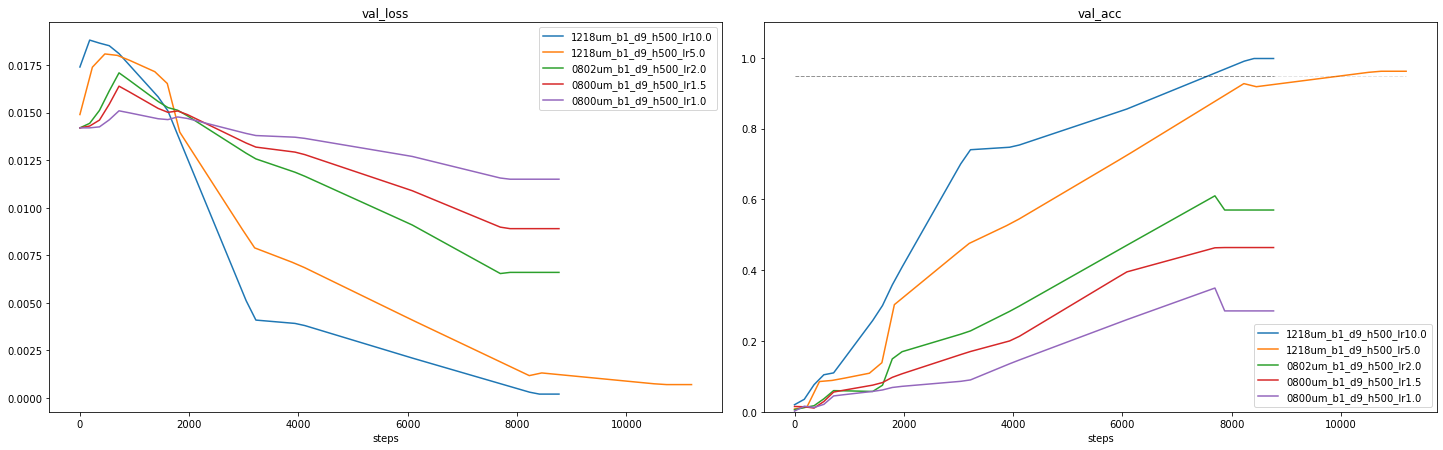

#logged paths : 4 
27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0 fold_0 val_loss 10, val_acc 10, Max_acc: 0.9 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0 fold_0 val_loss 10, val_acc 10, Max_acc: 0.581 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0 fold_0 val_loss 10, val_acc 10, Max_acc: 0.429 warning: val_step not in logs 
#folds: 1
Steps adjusted
27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5 fold_0 val_loss 10, val_acc 10, Max_acc: 0.147 warning: val_step not in logs 
#folds: 1
Steps adjusted


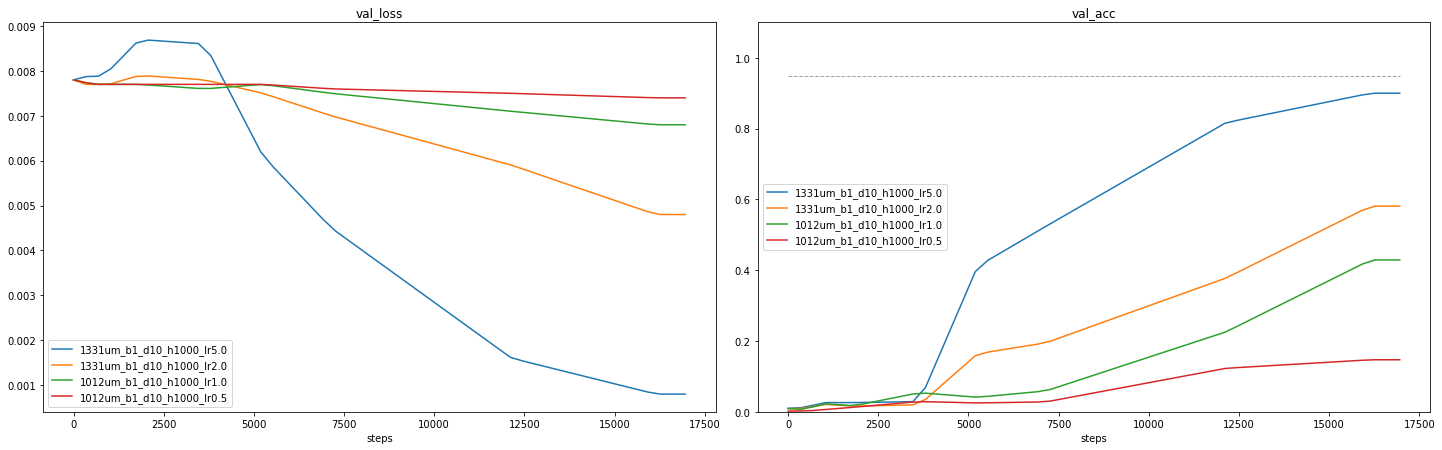

In [473]:
patts_to_search = ["b1_d5_h25_lr", "b1_d6_h25_lr",  "b1_d7_h100_lr", "b1_d8_h300_lr", "b1_d9_h500_lr", "b1_d10_h1000"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1, verbose=True) 

#logged paths : 8 
27156823_2704_1355_synth_um_b0_d5_h25_lr10.0 unsuccessful run
27156822_2704_1355_synth_um_b0_d5_h25_lr5.0 unsuccessful run
27160125_2804_1104_synth_um_b0_d5_h25_lr5.0 unsuccessful run
27172706_2904_2239_synth_um_b0_d5_h50_lr5.0 unsuccessful run
27172704_2904_2239_synth_um_b0_d5_h50_lr2.0 #folds: 2
Steps adjusted
27156821_2704_1354_synth_um_b0_d5_h25_lr2.0 #folds: 3
Steps adjusted
27156820_2704_1354_synth_um_b0_d5_h25_lr1.0 #folds: 1
Steps adjusted
27156819_2704_1354_synth_um_b0_d5_h25_lr0.5 #folds: 1
Steps adjusted


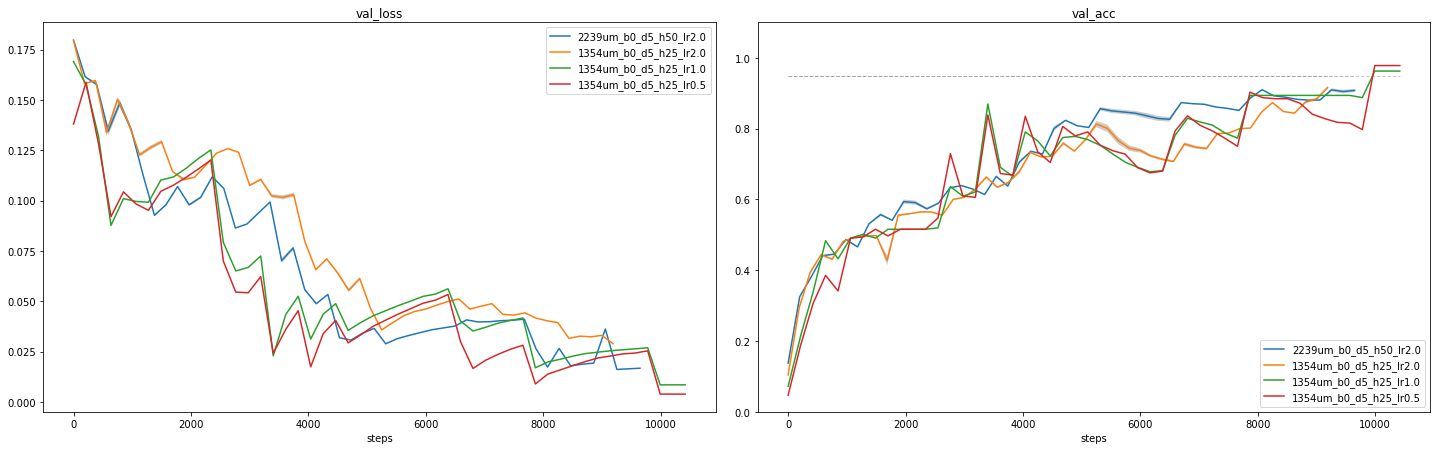

#logged paths : 6 
27158426_2704_2333_synth_um_b0_d6_h25_lr10.0 unsuccessful run
27158424_2704_2334_synth_um_b0_d6_h25_lr5.0 #folds: 2
Steps adjusted
27172711_2904_2242_synth_um_b0_d6_h50_lr5.0 #folds: 2
Steps adjusted
27158422_2704_2333_synth_um_b0_d6_h25_lr2.0 #folds: 2
Steps adjusted
27172709_2904_2241_synth_um_b0_d6_h50_lr2.0 #folds: 2
Steps adjusted
27158420_2704_2333_synth_um_b0_d6_h25_lr1.0 #folds: 2
Steps adjusted


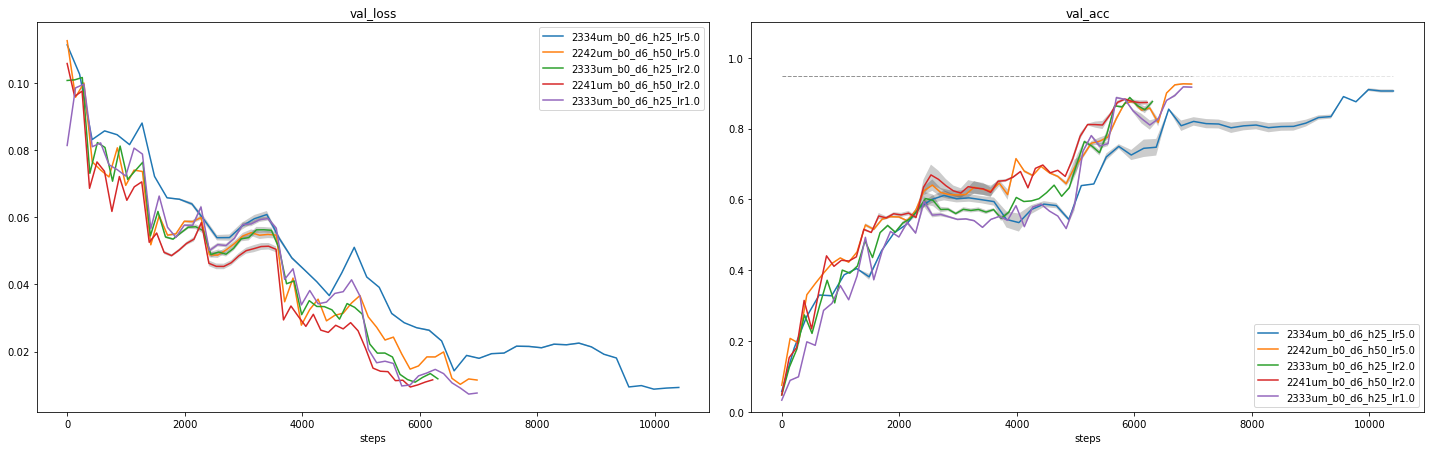

#logged paths : 18 
27157679_2704_2312_synth_um_b0_d7_h250_lr15.0 unsuccessful run
27157673_2704_2312_synth_um_b0_d7_h100_lr15.0 #folds: 2
Steps adjusted
27160134_2804_1104_synth_um_b0_d7_h50_lr10.0 #folds: 2
Steps adjusted
27157671_2704_2312_synth_um_b0_d7_h100_lr10.0 #folds: 2
Steps adjusted
27172870_2904_2334_synth_um_b0_d7_h200_lr10.0 #folds: 2
Steps adjusted
27149336_2604_1539_synth_um_b0_d7_h250_lr10.0 unsuccessful run
27172868_2904_2334_synth_um_b0_d7_h200_lr5.0 #folds: 2
Steps adjusted
27149339_2604_1541_synth_um_b0_d7_h150_lr5.0 unsuccessful run
27157675_2704_2312_synth_um_b0_d7_h250_lr5.0 #folds: 2
Steps adjusted
27160132_2804_1104_synth_um_b0_d7_h50_lr5.0 #folds: 2
Steps adjusted
27157669_2704_2312_synth_um_b0_d7_h100_lr5.0 #folds: 2
Steps adjusted
27147225_2504_1613_synth_um_b0_d7_h250_lr5.0 unsuccessful run
27166074_2904_1631_synth_um_b0_d7_h100_lr2.0 #folds: 2
Steps adjusted
27149335_2604_1533_synth_um_b0_d7_h250_lr2.0 unsuccessful run
27160130_2804_1104_synth_um_b0_d7_h5

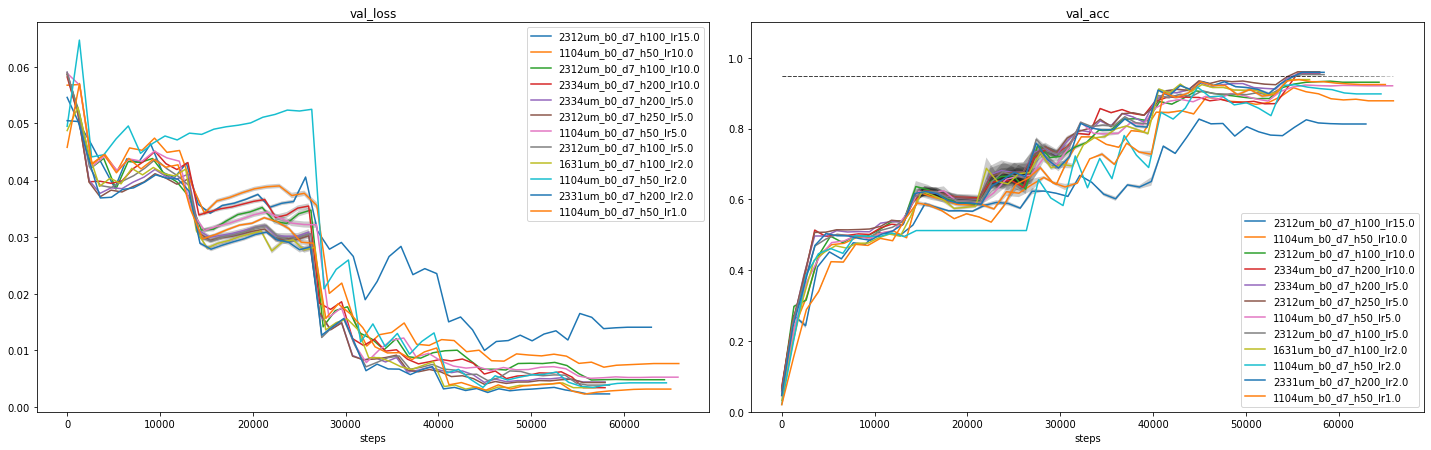

#logged paths : 12 
27160143_2804_1705_synth_um_b0_d8_h100_lr10.0 #folds: 2
Steps adjusted
27172877_2904_2355_synth_um_b0_d8_h400_lr10.0 #folds: 2
Steps adjusted
27160158_2804_2018_synth_um_b0_d8_h200_lr10.0 #folds: 2
Steps adjusted
27147228_2504_1617_synth_um_b0_d8_h300_lr5.0 warning: val_step not in logs #folds: 1
Steps adjusted
27160141_2804_1642_synth_um_b0_d8_h100_lr5.0 #folds: 2
Steps adjusted
27160156_2804_2006_synth_um_b0_d8_h200_lr5.0 #folds: 2
Steps adjusted
27172875_2904_2347_synth_um_b0_d8_h400_lr5.0 #folds: 2
Steps adjusted
27160154_2804_1705_synth_um_b0_d8_h200_lr2.0 #folds: 2
Steps adjusted
27160139_2804_1502_synth_um_b0_d8_h100_lr2.0 #folds: 2
Steps adjusted
27172873_2904_2335_synth_um_b0_d8_h400_lr2.0 #folds: 2
Steps adjusted
27160152_2804_1705_synth_um_b0_d8_h200_lr1.0 #folds: 1
Steps adjusted
27160137_2804_1136_synth_um_b0_d8_h100_lr1.0 #folds: 2
Steps adjusted


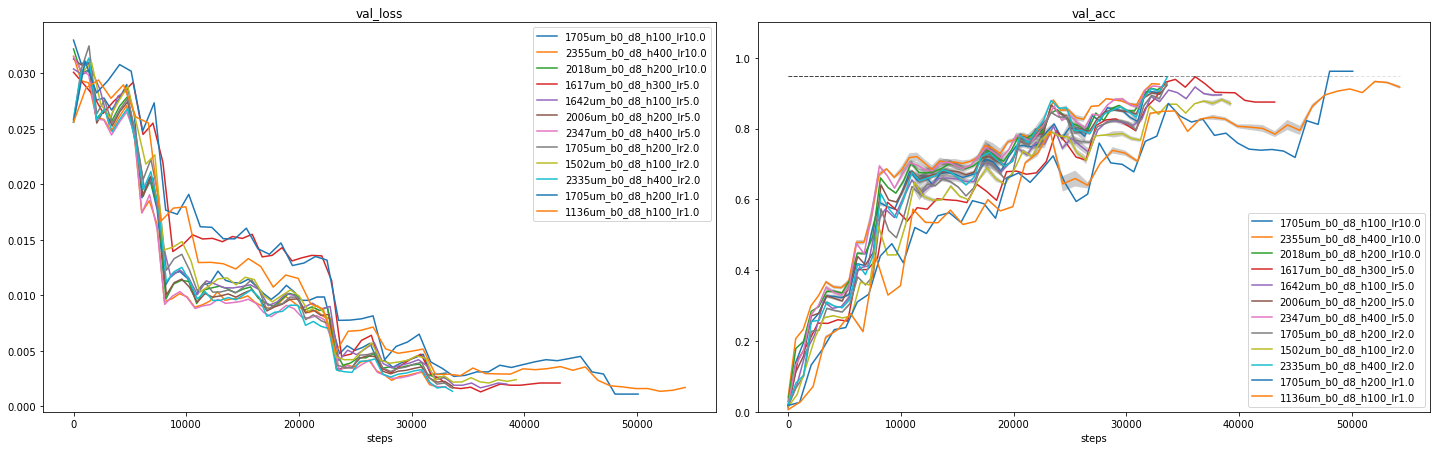

#logged paths : 7 
27160167_2804_2149_synth_um_b0_d9_h300_lr10.0 #folds: 2
Steps adjusted
27172884_3004_0131_synth_um_b0_d9_h300_lr10.0 #folds: 2
Steps adjusted
27172882_3004_0108_synth_um_b0_d9_h300_lr5.0 #folds: 2
Steps adjusted
27147230_2504_1618_synth_um_b0_d9_h500_lr5.0 warning: val_step not in logs #folds: 1
Steps adjusted
27172880_3004_0024_synth_um_b0_d9_h300_lr2.0 #folds: 2
Steps adjusted
27160163_2804_2111_synth_um_b0_d9_h300_lr2.0 #folds: 2
Steps adjusted
27160161_2804_2053_synth_um_b0_d9_h300_lr1.0 #folds: 2
Steps adjusted


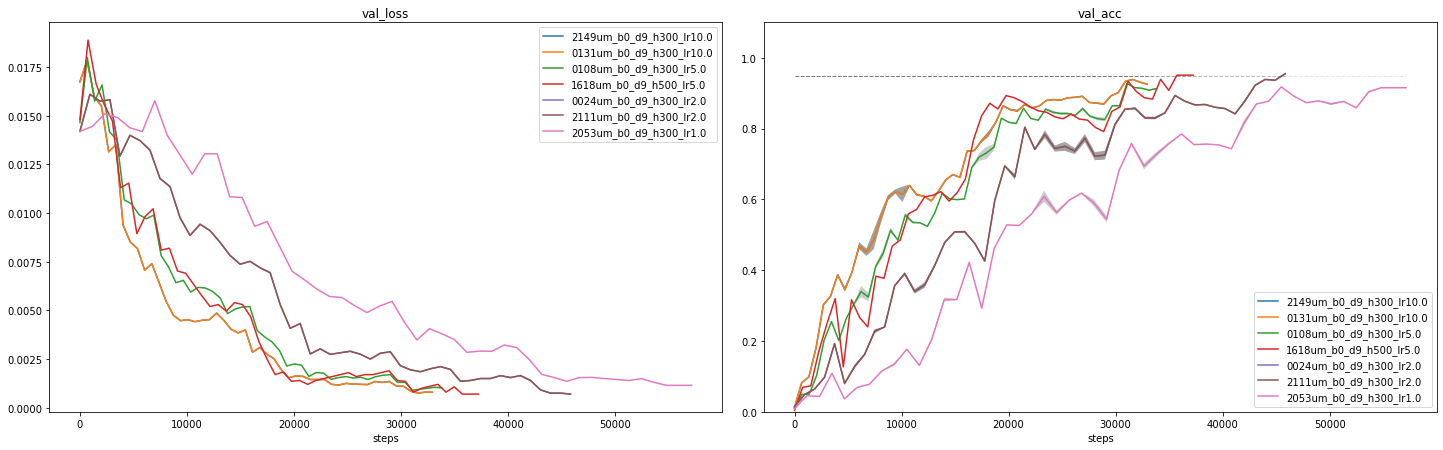

#logged paths : 8 
27172892_3004_0226_synth_um_b0_d10_h500_lr10.0 #folds: 2
Steps adjusted
27174499_3004_1449_synth_um_b0_d10_h500_lr10.0 #folds: 1
Steps adjusted
27172898_3004_0345_synth_um_b0_d10_h1000_lr10.0 #folds: 2
Steps adjusted
27174509_3004_1527_synth_um_b0_d10_h750_lr10.0 #folds: 2
Steps adjusted
27172896_3004_0319_synth_um_b0_d10_h1000_lr5.0 #folds: 2
Steps adjusted
27172890_3004_0157_synth_um_b0_d10_h500_lr5.0 #folds: 2
Steps adjusted
27172894_3004_0304_synth_um_b0_d10_h1000_lr2.0 #folds: 2
Steps adjusted
27172888_3004_0148_synth_um_b0_d10_h500_lr2.0 #folds: 2
Steps adjusted


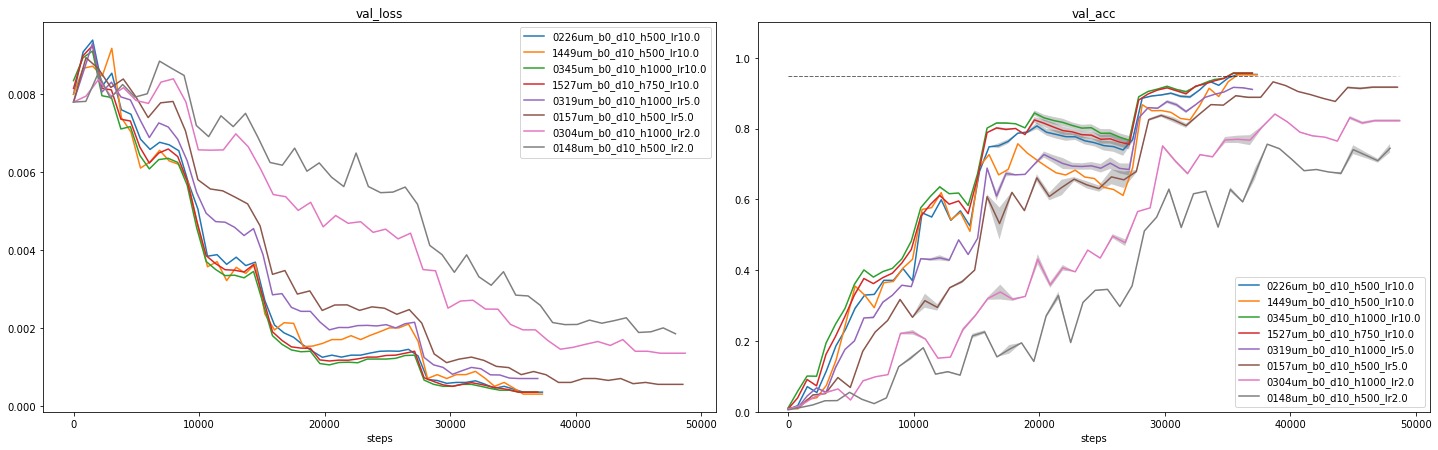

In [474]:
patts_to_search = ["um_b0_d5", "um_b0_d6",  "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10"]
for patt in patts_to_search: plot_runs_w_regex(patt, 0.8) 

#logged paths : 5 
27158432_2704_2337_synth_rand_b0_d5_h25_lr10.0 unsuccessful run
27158431_2704_2337_synth_rand_b0_d5_h25_lr5.0 #folds: 3
Steps adjusted
27158430_2704_2336_synth_rand_b0_d5_h25_lr2.0 #folds: 3
Steps adjusted
27166147_2904_1735_synth_rand_b0_d5_h10_lr2.0 #folds: 3
Steps adjusted
27158429_2704_2336_synth_rand_b0_d5_h25_lr1.0 #folds: 3
Steps adjusted


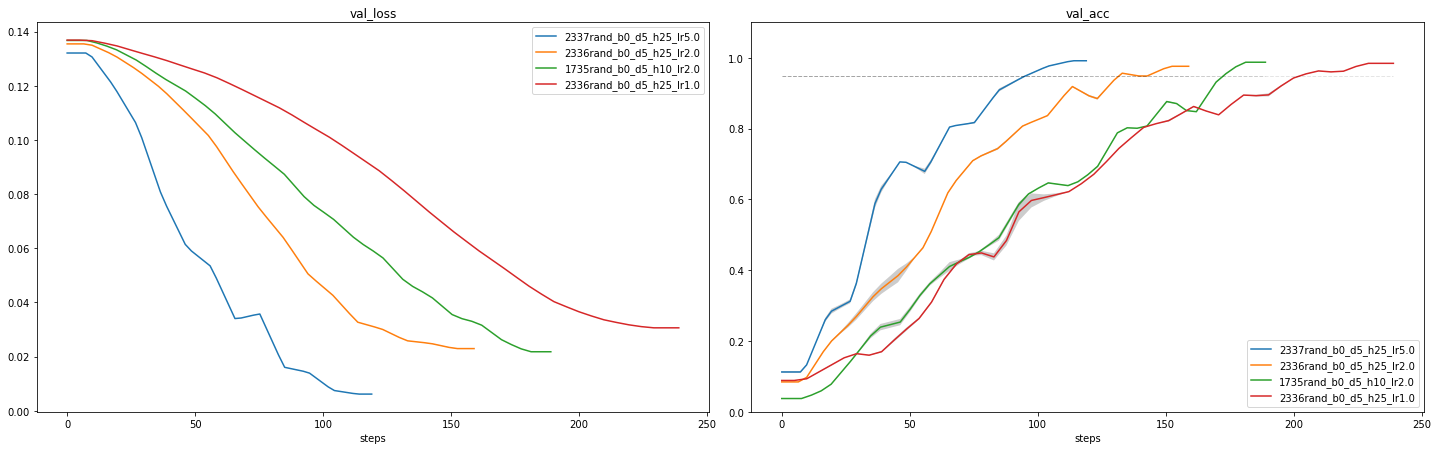

#logged paths : 6 
27158436_2704_2337_synth_rand_b0_d6_h25_lr10.0 #folds: 3
Steps adjusted
27158435_2704_2337_synth_rand_b0_d6_h25_lr5.0 #folds: 3
Steps adjusted
27158434_2704_2337_synth_rand_b0_d6_h25_lr2.0 #folds: 3
Steps adjusted
27166148_2904_1739_synth_rand_b0_d6_h10_lr2.0 #folds: 3
Steps adjusted
27166146_2904_1735_synth_rand_b0_d6_h5_lr2.0 #folds: 3
Steps adjusted
27158433_2704_2337_synth_rand_b0_d6_h25_lr1.0 #folds: 3
Steps adjusted


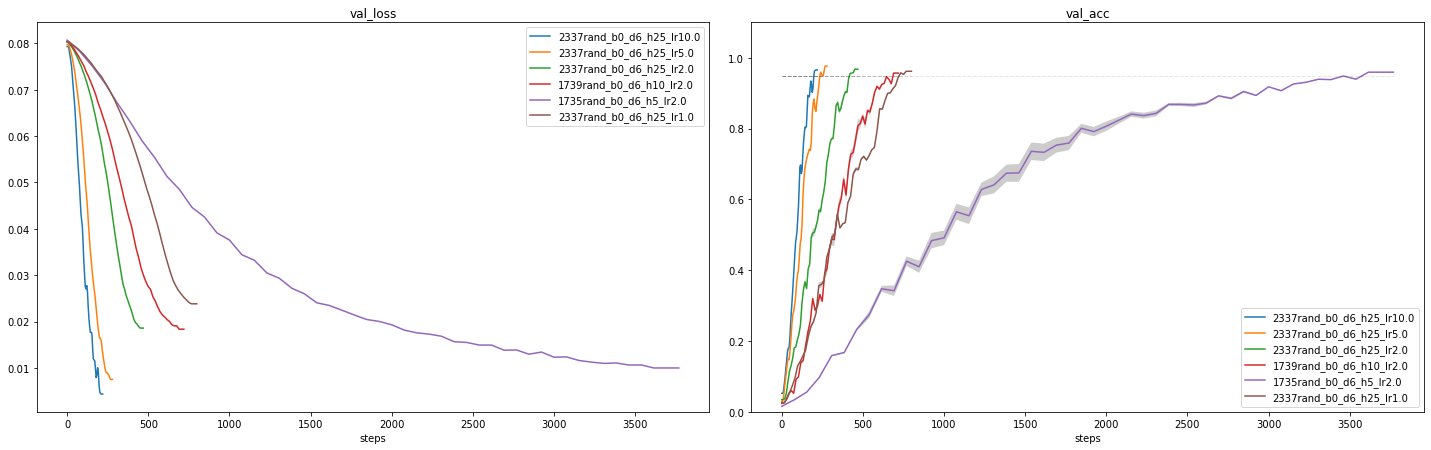

#logged paths : 7 
27158418_2704_2327_synth_rand_b0_d7_h250_lr5.0 #folds: 3
Steps adjusted
27166157_2904_1746_synth_rand_b0_d7_h25_lr5.0 #folds: 3
Steps adjusted
27158444_2704_2341_synth_rand_b0_d7_h100_lr5.0 #folds: 3
Steps adjusted
27166158_2904_1746_synth_rand_b0_d7_h40_lr5.0 #folds: 3
Steps adjusted
27146948_2504_1450_synth_rand_b0_d7_h250_lr5.0 warning: val_step not in logs warning: val_step not in logs warning: val_step not in logs warning: val_step not in logs #folds: 4
Steps adjusted
27158440_2704_2339_synth_rand_b0_d7_h50_lr5.0 #folds: 3
Steps adjusted
27158448_2704_2343_synth_rand_b0_d7_h200_lr5.0 #folds: 3
Steps adjusted


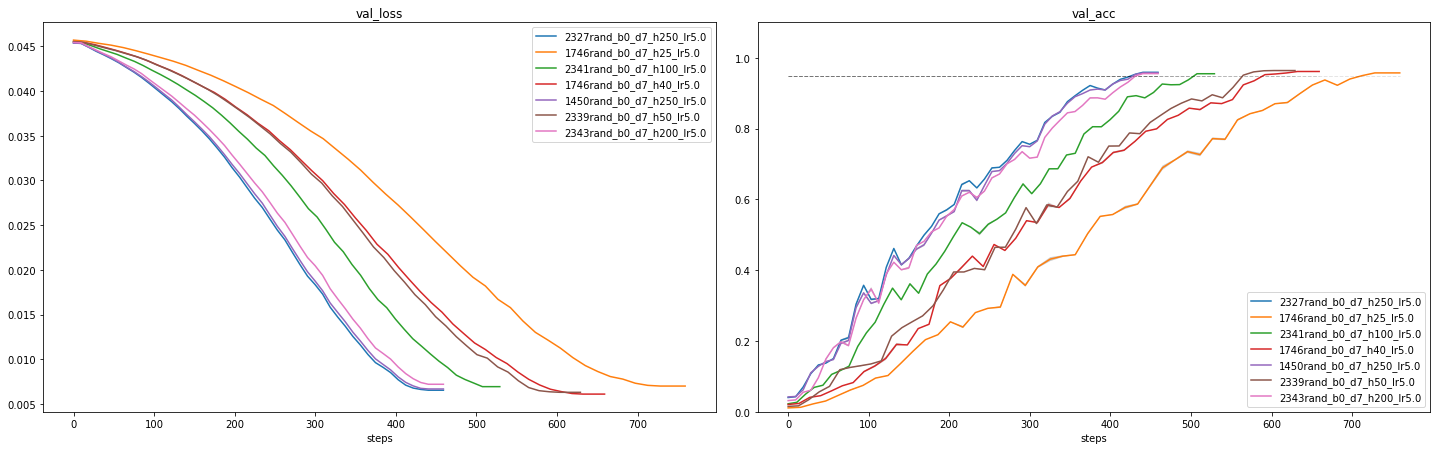

#logged paths : 4 
27158445_2704_2342_synth_rand_b0_d7_h100_lr10.0 #folds: 3
Steps adjusted
27158444_2704_2341_synth_rand_b0_d7_h100_lr5.0 #folds: 3
Steps adjusted
27158443_2704_2340_synth_rand_b0_d7_h100_lr2.0 #folds: 3
Steps adjusted
27158442_2704_2340_synth_rand_b0_d7_h100_lr1.0 #folds: 3
Steps adjusted


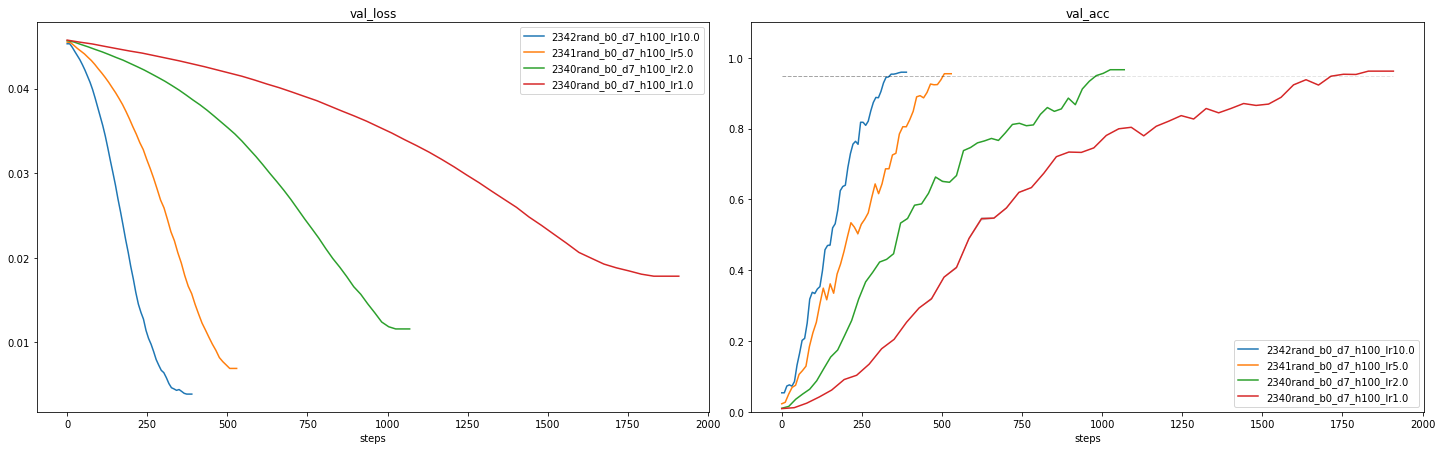

#logged paths : 15 
27158458_2704_2348_synth_rand_b0_d8_h200_lr10.0 #folds: 3
Steps adjusted
27158462_2704_2350_synth_rand_b0_d8_h300_lr10.0 #folds: 3
Steps adjusted
27158454_2704_2346_synth_rand_b0_d8_h100_lr10.0 #folds: 3
Steps adjusted
27166152_2904_1739_synth_rand_b0_d8_h25_lr5.0 #folds: 3
Steps adjusted
27166154_2904_1743_synth_rand_b0_d8_h75_lr5.0 #folds: 3
Steps adjusted
27158453_2704_2346_synth_rand_b0_d8_h100_lr5.0 #folds: 3
Steps adjusted
27158457_2704_2347_synth_rand_b0_d8_h200_lr5.0 #folds: 3
Steps adjusted
27166153_2904_1739_synth_rand_b0_d8_h50_lr5.0 #folds: 3
Steps adjusted
27158461_2704_2350_synth_rand_b0_d8_h300_lr5.0 #folds: 3
Steps adjusted
27158460_2704_2349_synth_rand_b0_d8_h300_lr2.0 #folds: 3
Steps adjusted
27158456_2704_2347_synth_rand_b0_d8_h200_lr2.0 #folds: 3
Steps adjusted
27158452_2704_2346_synth_rand_b0_d8_h100_lr2.0 #folds: 3
Steps adjusted
27158459_2704_2349_synth_rand_b0_d8_h300_lr1.0 #folds: 3
Steps adjusted
27158451_2704_2345_synth_rand_b0_d8_h100_lr1

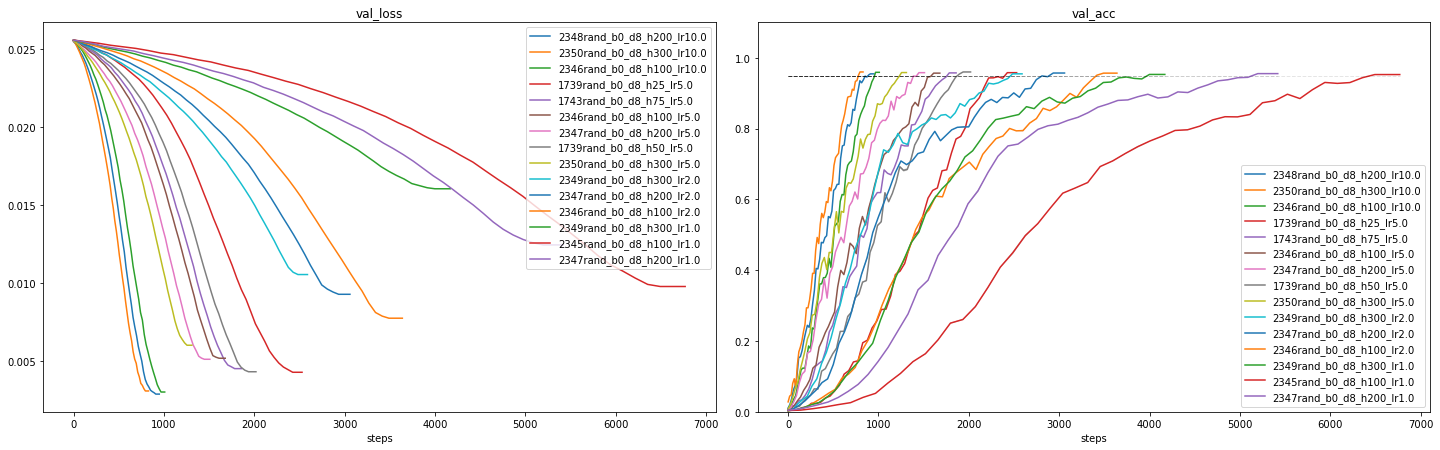

#logged paths : 14 
27158467_2704_2351_synth_rand_b0_d9_h300_lr10.0 #folds: 3
Steps adjusted
27158471_2704_2356_synth_rand_b0_d9_h400_lr10.0 #folds: 3
Steps adjusted
27158475_2804_0005_synth_rand_b0_d9_h500_lr10.0 #folds: 3
Steps adjusted
27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0 warning: val_step not in logs warning: val_step not in logs warning: val_step not in logs #folds: 3
Steps adjusted
27158466_2704_2351_synth_rand_b0_d9_h300_lr5.0 #folds: 3
Steps adjusted
27158470_2704_2354_synth_rand_b0_d9_h400_lr5.0 #folds: 3
Steps adjusted
27166162_2904_1746_synth_rand_b0_d9_h50_lr5.0 #folds: 3
Steps adjusted
27166163_2904_1750_synth_rand_b0_d9_h100_lr5.0 #folds: 3
Steps adjusted
27158465_2704_2351_synth_rand_b0_d9_h300_lr2.0 #folds: 3
Steps adjusted
27158473_2704_2357_synth_rand_b0_d9_h500_lr2.0 #folds: 3
Steps adjusted
27158469_2704_2353_synth_rand_b0_d9_h400_lr2.0 #folds: 3
Steps adjusted
27158464_2704_2351_synth_rand_b0_d9_h300_lr1.0 #folds: 3
Steps adjusted
27158468_2704_2351_synth

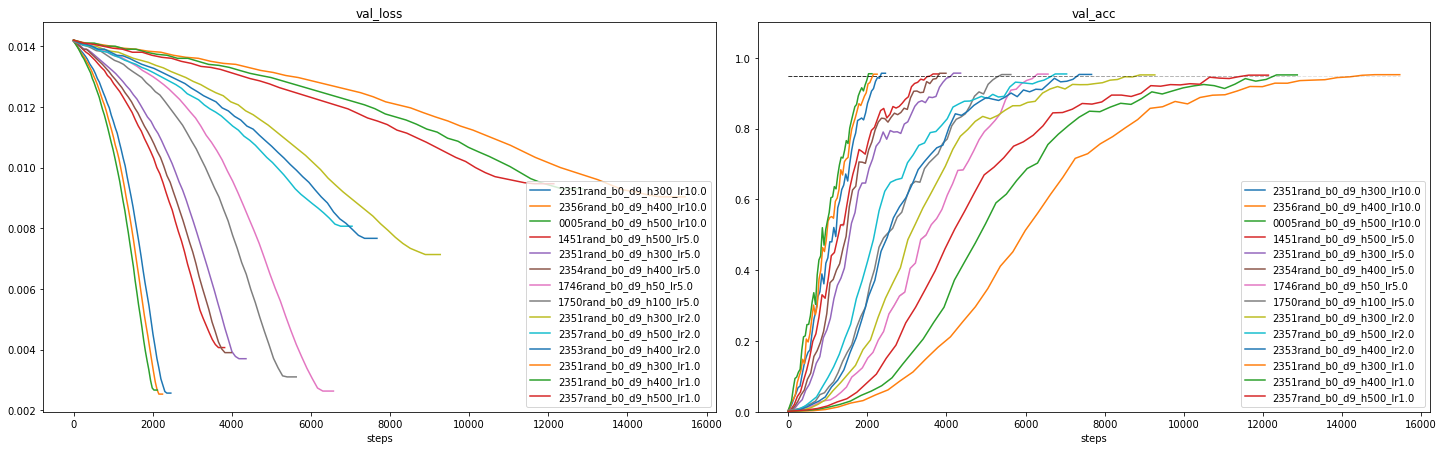

#logged paths : 8 
27172864_2904_2331_synth_rand_b0_d10_h750_lr10.0 #folds: 3
Steps adjusted
27172862_2904_2325_synth_rand_b0_d10_h500_lr10.0 #folds: 3
Steps adjusted
27166166_2904_1754_synth_rand_b0_d10_h400_lr5.0 #folds: 3
Steps adjusted
27156825_2704_1355_synth_rand_b0_d10_h1000_lr5.0 #folds: 3
Steps adjusted
27172861_2904_2325_synth_rand_b0_d10_h500_lr5.0 #folds: 3
Steps adjusted
27166164_2904_1750_synth_rand_b0_d10_h100_lr5.0 #folds: 2
Steps adjusted
27172863_2904_2325_synth_rand_b0_d10_h750_lr5.0 #folds: 3
Steps adjusted
27166165_2904_1751_synth_rand_b0_d10_h200_lr5.0 unsuccessful run


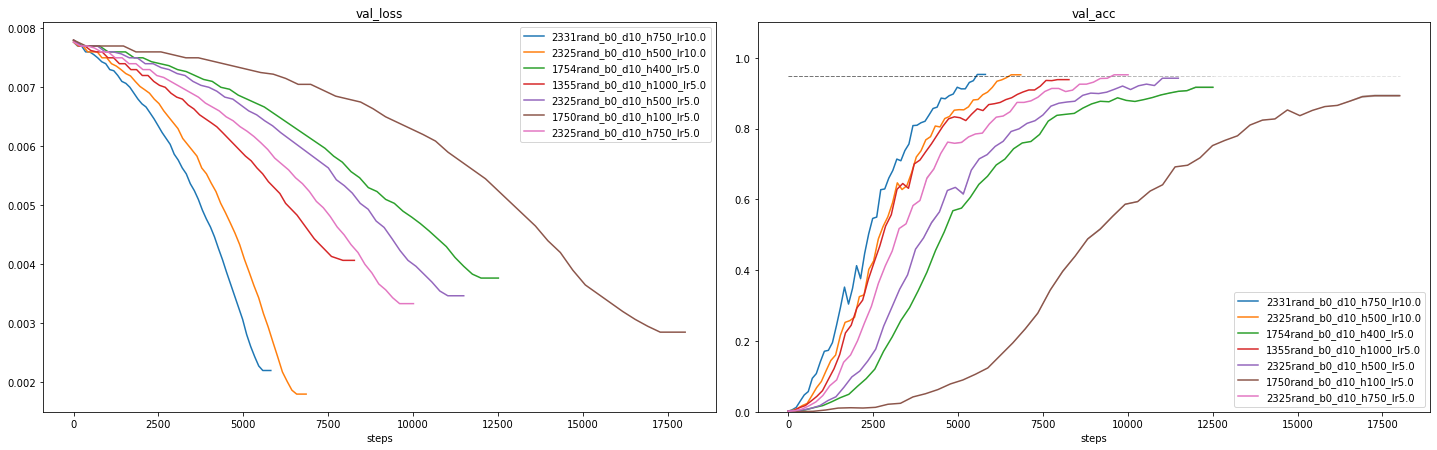

In [475]:

patts_to_search1 = ["rand[a-z0-9_]*d5","rand[a-z0-9_]*d6",
                   "rand[a-z0-9_]*d7[a-z0-9_]*lr5", "rand[a-z0-9_]*d7_h100", "rand[a-z0-9_]*d8_h", "rand[a-z0-9_]*d9_h", "rand[a-z0-9_]*d10_h"]

for patt in patts_to_search1: plot_runs_w_regex(patt, 0.2, LOG_PATH) 

#logged paths : 6 
27156823_2704_1355_synth_um_b0_d5_h25_lr10.0 unsuccessful run
27156822_2704_1355_synth_um_b0_d5_h25_lr5.0 unsuccessful run
27160125_2804_1104_synth_um_b0_d5_h25_lr5.0 unsuccessful run
27156821_2704_1354_synth_um_b0_d5_h25_lr2.0 #folds: 3
Steps adjusted
27156820_2704_1354_synth_um_b0_d5_h25_lr1.0 #folds: 1
Steps adjusted
27156819_2704_1354_synth_um_b0_d5_h25_lr0.5 #folds: 1
Steps adjusted


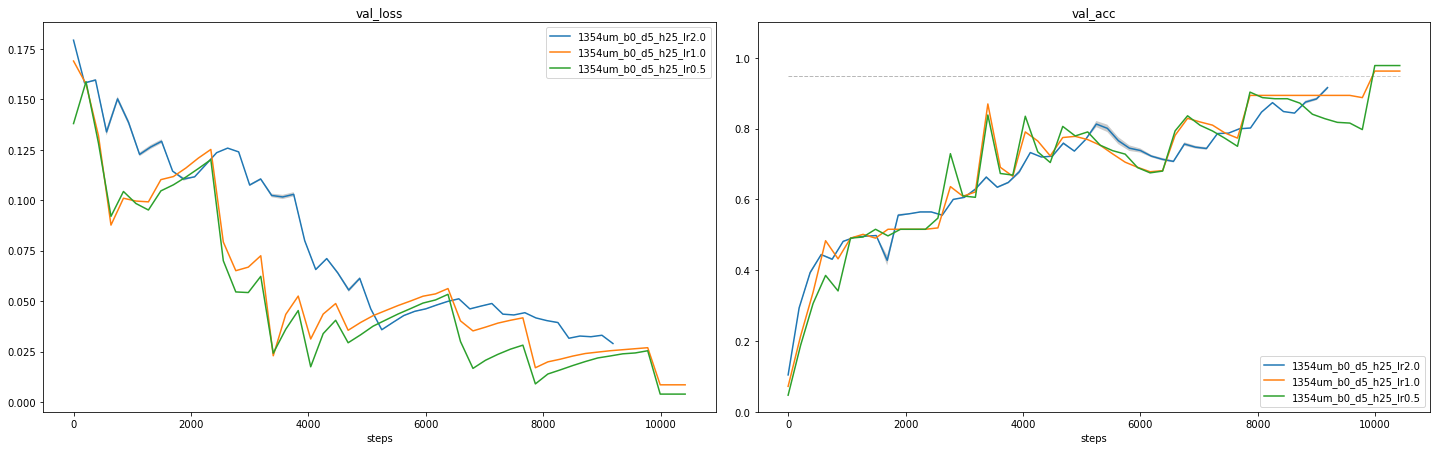

#logged paths : 4 
27158426_2704_2333_synth_um_b0_d6_h25_lr10.0 unsuccessful run
27158424_2704_2334_synth_um_b0_d6_h25_lr5.0 #folds: 2
Steps adjusted
27158422_2704_2333_synth_um_b0_d6_h25_lr2.0 #folds: 2
Steps adjusted
27158420_2704_2333_synth_um_b0_d6_h25_lr1.0 #folds: 2
Steps adjusted


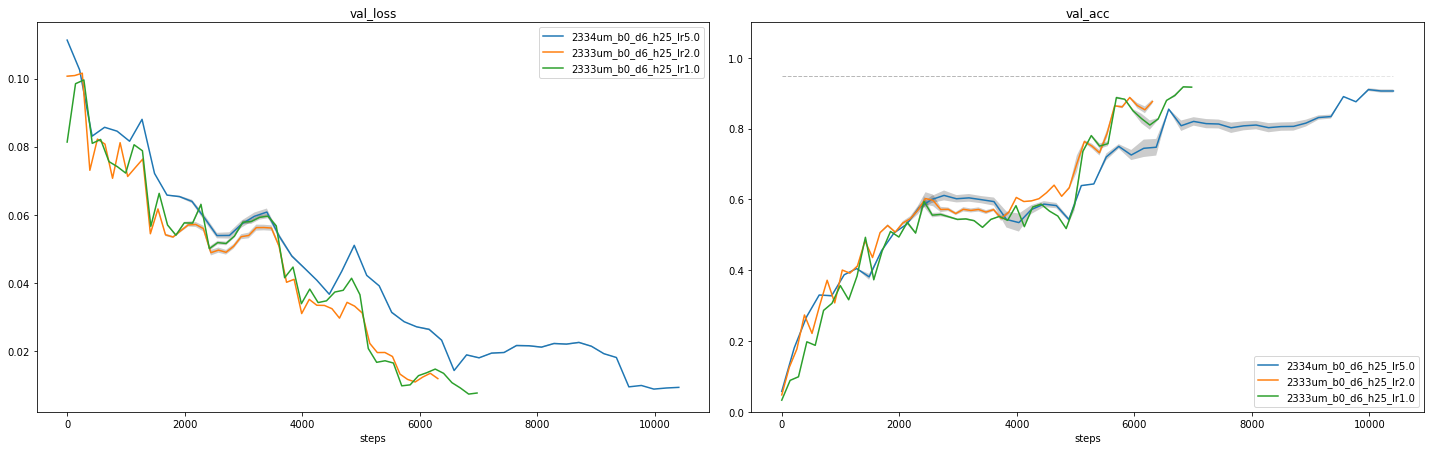

#logged paths : 4 
27157673_2704_2312_synth_um_b0_d7_h100_lr15.0 #folds: 2
Steps adjusted
27157671_2704_2312_synth_um_b0_d7_h100_lr10.0 #folds: 2
Steps adjusted
27157669_2704_2312_synth_um_b0_d7_h100_lr5.0 #folds: 2
Steps adjusted
27166074_2904_1631_synth_um_b0_d7_h100_lr2.0 #folds: 2
Steps adjusted


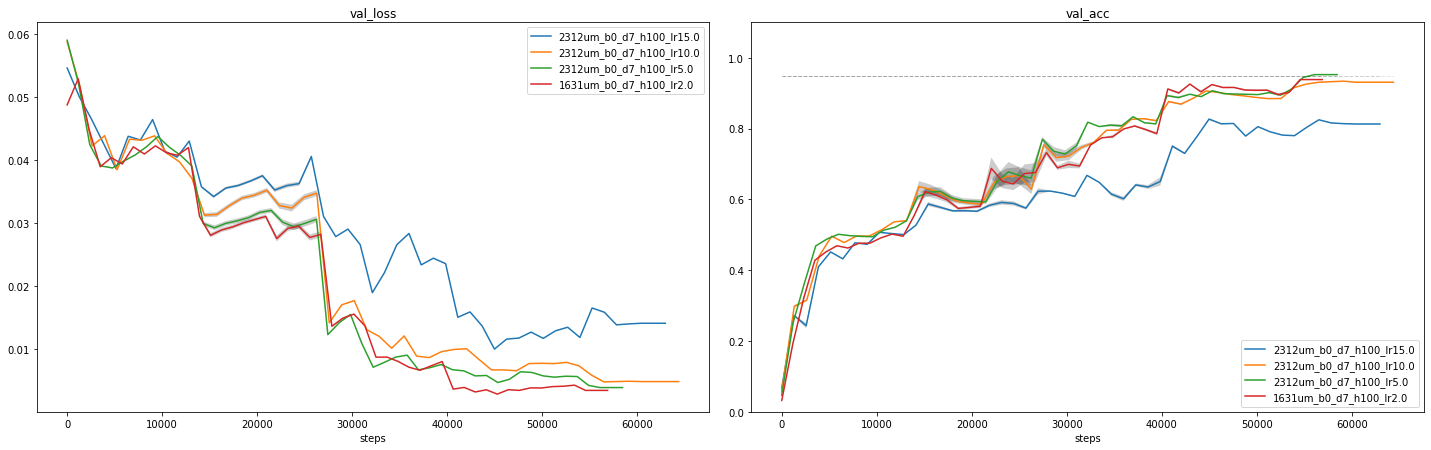

#logged paths : 4 
27160158_2804_2018_synth_um_b0_d8_h200_lr10.0 #folds: 2
Steps adjusted
27160156_2804_2006_synth_um_b0_d8_h200_lr5.0 #folds: 2
Steps adjusted
27160154_2804_1705_synth_um_b0_d8_h200_lr2.0 #folds: 2
Steps adjusted
27160152_2804_1705_synth_um_b0_d8_h200_lr1.0 #folds: 1
Steps adjusted


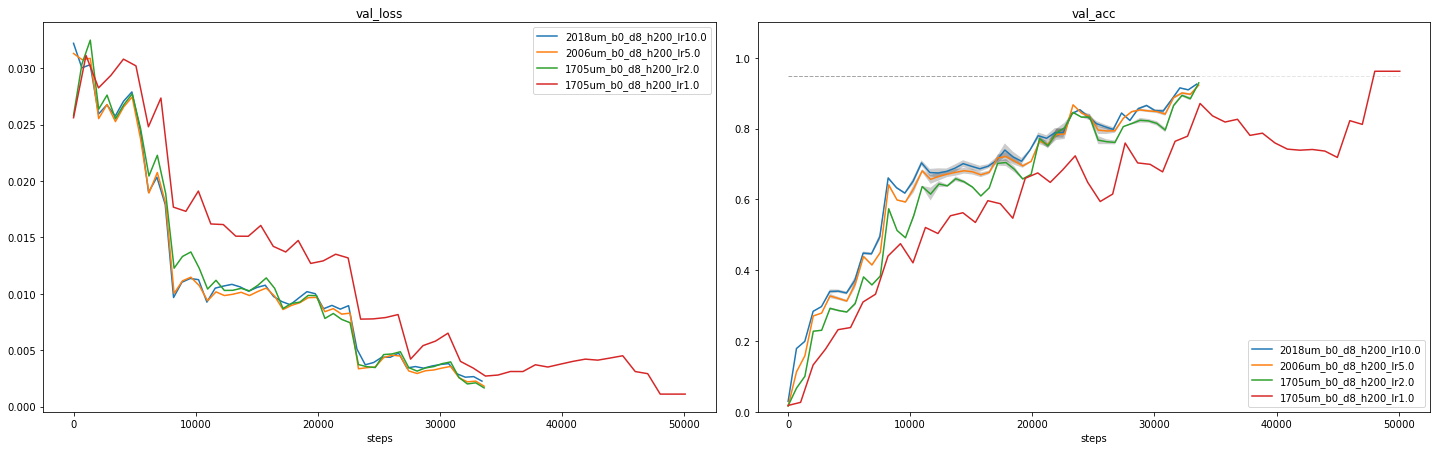

#logged paths : 1 
27147230_2504_1618_synth_um_b0_d9_h500_lr5.0 warning: val_step not in logs #folds: 1
Steps adjusted


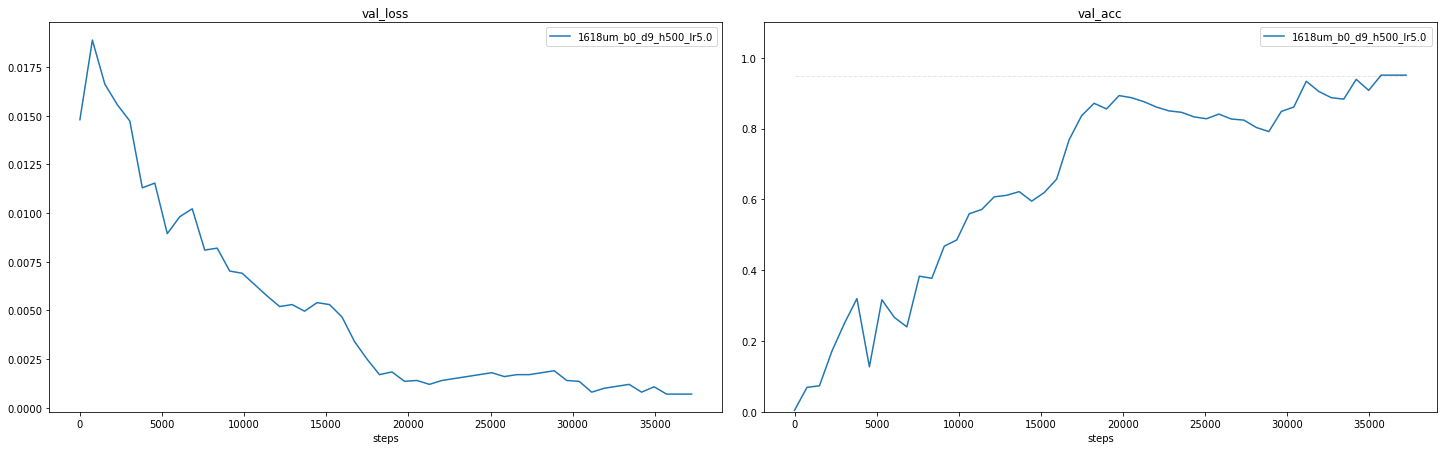

In [476]:
patts_to_search2 = ["um_b0[a-z0-9_]*d5_h25","um_b0[a-z0-9_]*d6_h25", "um_b0[a-z0-9_]*d7_h100", "um_b0[a-z0-9_]*d8_h200", "um_b0[a-z0-9_]*d9_h500"]
for patt in patts_to_search2: plot_runs_w_regex(patt, 0.2, LOG_PATH)


#logged paths : 4 
27197385_0505_1836_synth_um_b1_d5_h25_lr2.0 fold_0 #logged: 11, Max_acc: 0.959 Max_step: 4032 
fold_1 #logged: 21, Max_acc: 0.934 Max_step: 8043 
#folds: 2
27197389_0505_1836_synth_um_b10_d5_h25_lr2.0 fold_0 #logged: 9, Max_acc: 1.0 Max_step: 4035 
fold_1 #logged: 18, Max_acc: 0.956 Max_step: 8540 
#folds: 2
27197391_0505_1836_synth_um_b100_d5_h25_lr2.0 fold_0 #logged: 12, Max_acc: 0.972 Max_step: 7732 
fold_1 #logged: 9, Max_acc: 0.953 Max_step: 5628 
#folds: 2
27197394_0505_1837_synth_um_b1000_d5_h25_lr2.0 fold_0 #logged: 4, Max_acc: 1.0 Max_step: 12014 
fold_1 #logged: 4, Max_acc: 1.0 Max_step: 12023 
#folds: 2


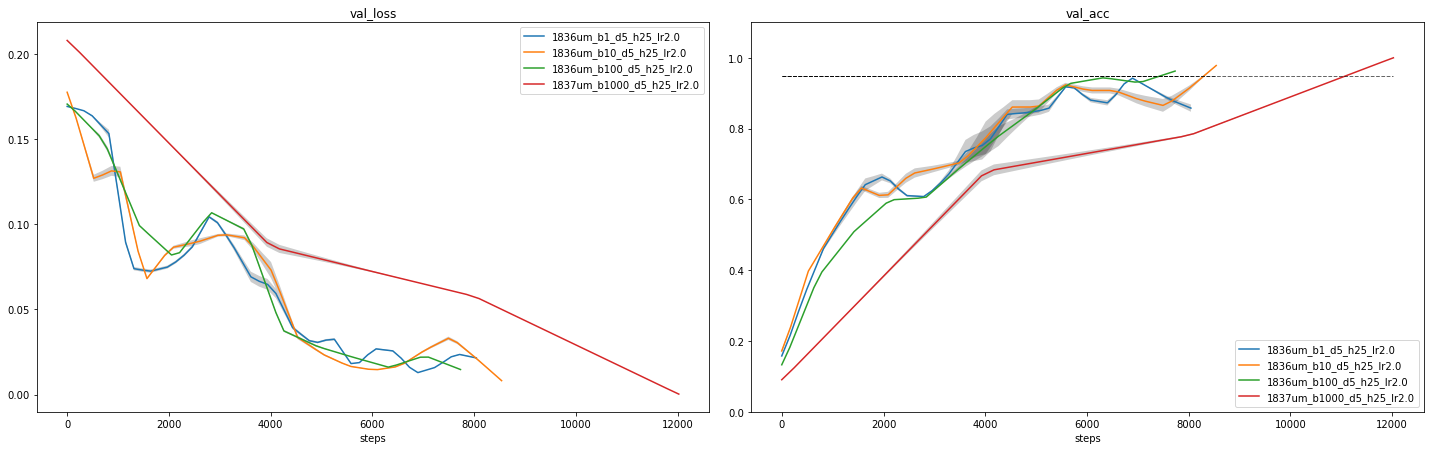

#logged paths : 3 
27197399_0505_1837_synth_um_b10_d6_h25_lr2.0 fold_0 #logged: 14, Max_acc: 0.984 Max_step: 6537 
fold_1 #logged: 17, Max_acc: 0.959 Max_step: 8041 
#folds: 2
27197400_0505_1837_synth_um_b100_d6_h25_lr2.0 fold_0 #logged: 10, Max_acc: 0.975 Max_step: 7252 
fold_1 #logged: 15, Max_acc: 0.969 Max_step: 11241 
#folds: 2
27197403_0505_1841_synth_um_b1000_d6_h25_lr2.0 fold_0 #logged: 3, Max_acc: 0.975 Max_step: 8033 
fold_1 #logged: 4, Max_acc: 0.97 Max_step: 12017 
#folds: 2


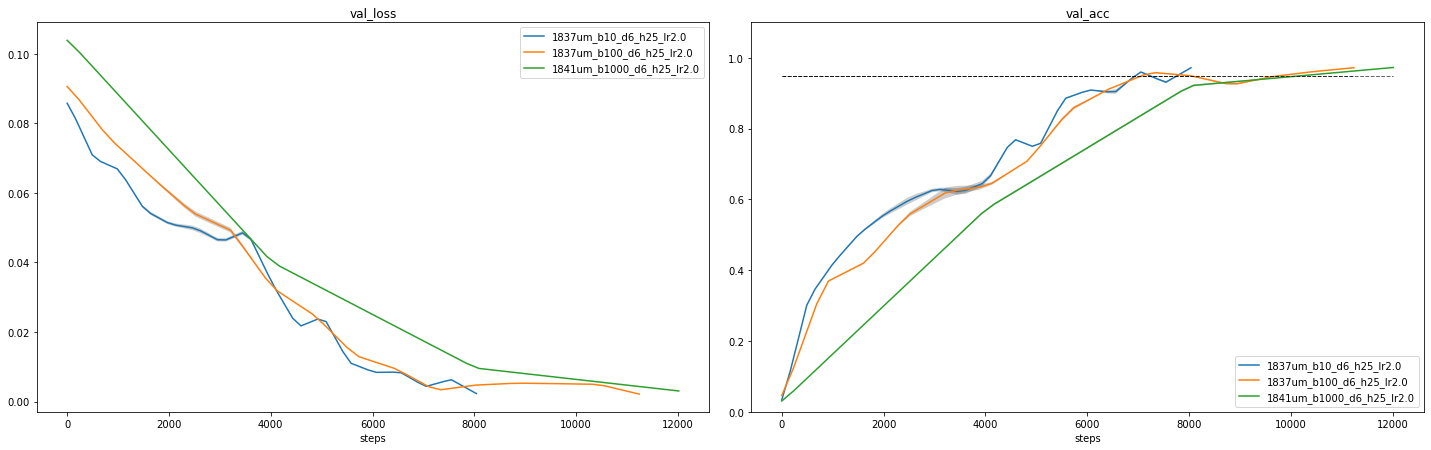

#logged paths : 10 
27200034_0605_1215_synth_um_b1_d7_h100_lr2.0 fold_0 #logged: 3, Max_acc: 0.757 Max_step: 40129 
fold_1 #logged: 3, Max_acc: 0.91 Max_step: 40103 
#folds: 2
27200032_0605_1209_synth_um_b10_d7_h100_lr2.0 fold_0 #logged: 3, Max_acc: 0.753 Max_step: 40076 
fold_1 #logged: 19, Max_acc: 0.509 unsuccessful run
27197318_0505_1426_synth_um_b10_d7_h100_lr2.0 fold_0 #logged: 18, Max_acc: 0.507 unsuccessful run
27200028_0605_1152_synth_um_b100_d7_h100_lr2.0 fold_0 #logged: 3, Max_acc: 0.748 Max_step: 40080 
fold_1 #logged: 6, Max_acc: 0.8 Max_step: 25047 
#folds: 2
27197443_0505_1854_synth_um_b100_d7_h100_lr2.0 fold_0 #logged: 6, Max_acc: 0.512 unsuccessful run
27200023_0605_1142_synth_um_b1000_d7_h400_lr2.0 fold_0 #logged: 3, Max_acc: 0.774 Max_step: 40027 
fold_1 #logged: 3, Max_acc: 0.93 Max_step: 40025 
#folds: 2
27200021_0605_1142_synth_um_b1000_d7_h100_lr2.0 fold_0 #logged: 3, Max_acc: 0.744 Max_step: 40027 
fold_1 #logged: 6, Max_acc: 0.773 Max_step: 25064 
#folds: 2
271

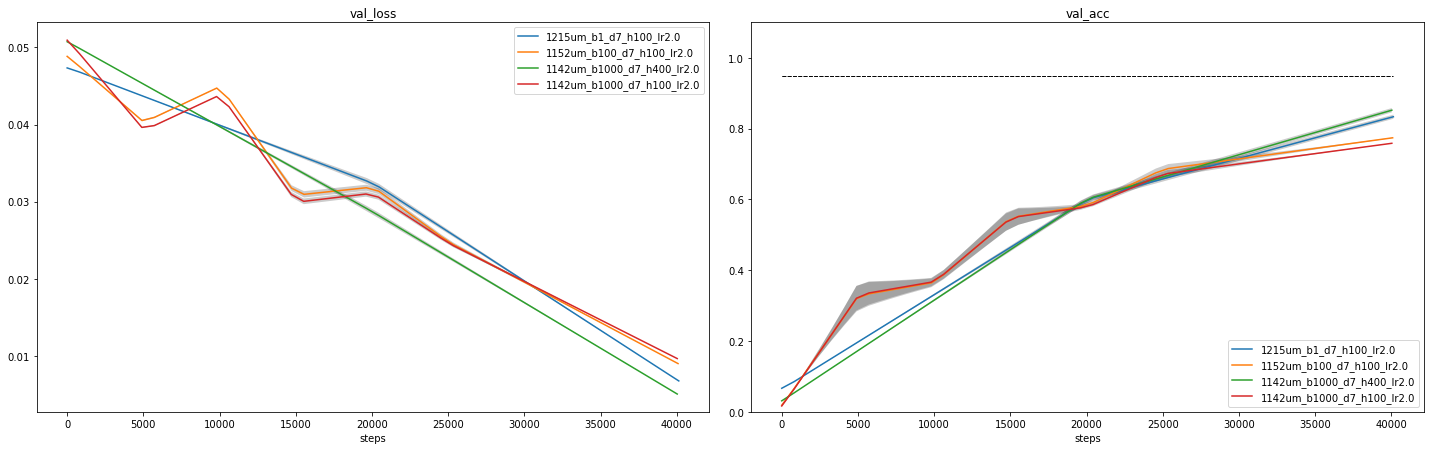

#logged paths : 2 
27197326_0505_1436_synth_um_b1_d8_h200_lr5.0 fold_0 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged: 9, Max_acc: 0.624 unsuccessful run
27197330_0505_1803_synth_um_b10_d8_h200_lr5.0 fold_0 #logged: 13, Max_acc: 0.616 unsuccessful run


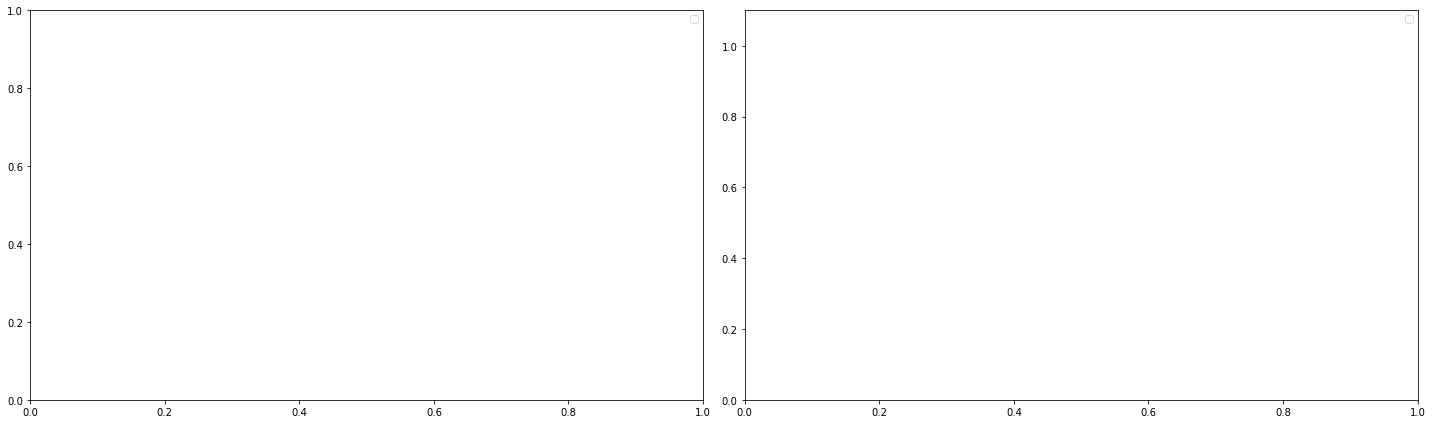

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 2 
27197337_0505_1833_synth_um_b1_d9_h300_lr5.0 fold_0 #logged: 9, Max_acc: 0.587 unsuccessful run
27197334_0505_1828_synth_um_b10_d9_h300_lr5.0 fold_0 #logged: 13, Max_acc: 0.56 unsuccessful run


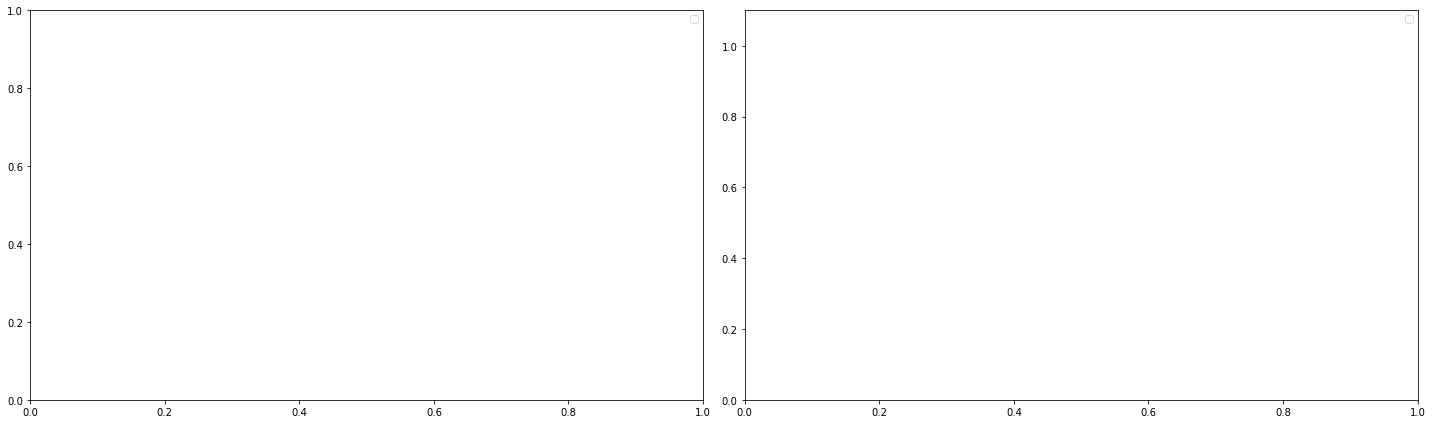

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


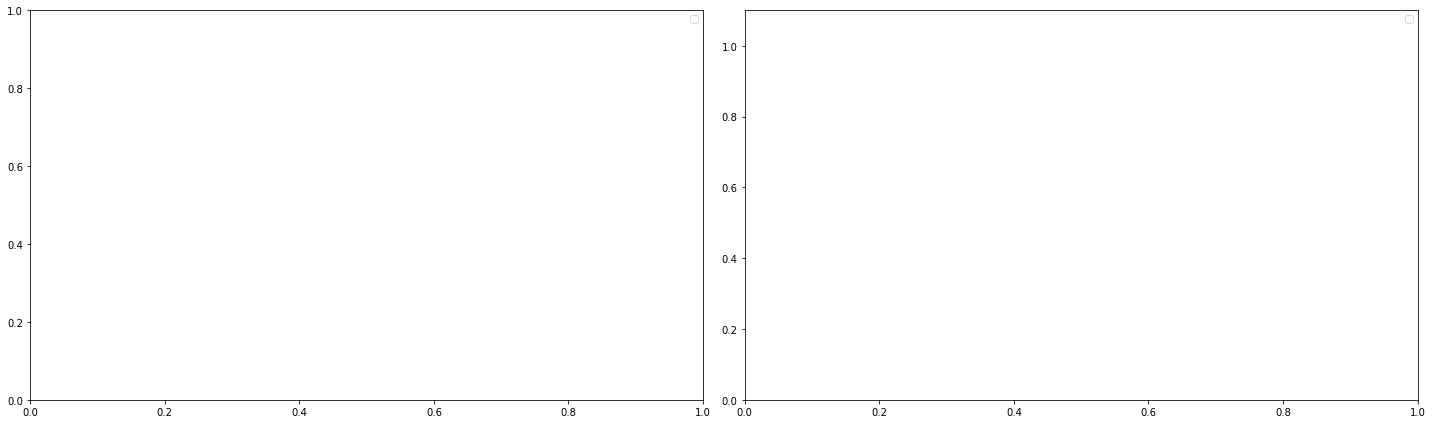

In [618]:
patts_to_search2 = ["um_b0_d5", "um_b0_d6", "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10", 
                    "rand_b0_d5", "rand_b0_d6", "rand_b0_d7", "rand_b0_d8", "rand_b0_d9", "rand_b0_d10"]

patts_to_search2 = ["d5_h25", "d6", "d7", "d8", "d9", "d10"]
#patts_to_search2 = ["1836_synth_um_b1_d5"]

for patt in patts_to_search2: plot_runs_w_regex(patt, 0.7, DL_LOG_PATH, verbose=True)

# Log folds merger

In [614]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def merge_folds(log_path=LOG_PATH):
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    patt = "([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    idx_true = [int(m.group(1)) > 27166099 for m in matched] # keep only recent matches
    matched = np.array(matched)[idx_true]
    all_ckpt_dirs = np.array(all_ckpt_dirs)[idx_true]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    
    all_ckpt_dirs = [[join(log_path, fold) for fold in folds] for folds in folds_to_merge]
    for folds in all_ckpt_dirs: 
        for fold in folds: assert(os.path.isdir(fold))
    
    for folds in all_ckpt_dirs:
        # find fold 0
        for i, fold in enumerate(folds):
            list_metrics_fold_x = os.listdir(fold)
            fold_x = [el for el in list_metrics_fold_x if ("metrics" not in el and "DS_Store" not in el)][0]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            if fold_nb == 0:
                del folds[i]
                dest_path = join(fold, "metrics")
                break
        
        merged_folds_nb = [fold_nb]
        for fold in folds:
            list_metrics_fold_x = os.listdir(fold)
            fold_x = [el for el in list_metrics_fold_x if ("metrics" not in el and "DS_Store" not in el)][0]
            foldnb2 = int(re.match('fold_([0-9]+)', fold_x).group(1))
            
            metrics_fold = join(fold, "metrics")
            dirs_list = os.listdir(metrics_fold)
            dirs_list = [el for el in list_metrics_fold_x if ("metrics" not in el and "DS_Store" not in el)]
            if len(dirs_list) == 0:
                print(22)
                continue
            source_path = join(metrics_fold, dirs_list[0])
            
            print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            if not foldnb2 in merged_folds_nb:
                merged_folds_nb.append(foldnb2)

                # Check if file already exists
                hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
                if os.path.isdir(hyp_dest_path):
                    print(hyp_dest_path,'exists in the destination path!')
                    shutil.rmtree(hyp_dest_path)

                shutil.move(source_path, dest_path)

                folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
                print("TO remove", folder)
                shutil.rmtree(folder)

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
merge_folds(DL_LOG_PATH)


[array(['27200028_0605_1152_synth_um_b100_d7_h100_lr2.0',
       '27197444_0505_1901_synth_um_b100_d7_h100_lr2.0',
       '27197443_0505_1854_synth_um_b100_d7_h100_lr2.0'], dtype='<U47'), array(['27197385_0505_1836_synth_um_b1_d5_h25_lr2.0',
       '27200016_0605_1136_synth_um_b1_d5_h25_lr2.0',
       '27197386_0505_1836_synth_um_b1_d5_h25_lr2.0'], dtype='<U47'), array(['27197447_0505_1902_synth_um_b1000_d7_h100_lr2.0',
       '27200021_0605_1142_synth_um_b1000_d7_h100_lr2.0',
       '27197446_0505_1901_synth_um_b1000_d7_h100_lr2.0'], dtype='<U47'), array(['27197319_0505_1436_synth_um_b10_d7_h100_lr2.0',
       '27200032_0605_1209_synth_um_b10_d7_h100_lr2.0',
       '27197318_0505_1426_synth_um_b10_d7_h100_lr2.0'], dtype='<U47')]
dest_fold_nb ../dl_logs/logs/27200028_0605_1152_synth_um_b100_d7_h100_lr2.0/metrics [0] foldnb2 ../dl_logs/logs/27197444_0505_1901_synth_um_b100_d7_h100_lr2.0/metrics/fold_1 1
../dl_logs/logs/27200028_0605_1152_synth_um_b100_d7_h100_lr2.0/metrics/fold_1 exists

[200, 500, 1000, 1300, 1700, 2200, 2900, 3800, 4900, 6400, 8300] 11
[300, 700, 1500, 1900, 2500, 3300, 4300, 5700, 7400, 9600, 12500] 11


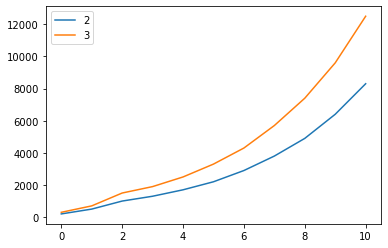

In [631]:
b_l=100

for a in range(2,4):
    a0=a
    b=[]
    for i in range(17):
        if i < 9: 
            #a*=2.8
            a*=2
        else:
            a*=1.3
        b.append(a)
    b = [int((el // b_l) * b_l) for el in b] 
    b = [el for el in b if el > b_l] 
    print(b, len(b))
    plt.plot(b, label=a0)    
plt.legend()
plt.show()

In [607]:
a = 0 if True else 1
a

0